<a href="https://colab.research.google.com/github/nem-42098/SL_Proj_Unlearning/blob/main/Unlearn_test_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nem-42098/SL_Proj_Unlearning.git
import os
os.chdir('/content/SL_Proj_Unlearning')

Cloning into 'SL_Proj_Unlearning'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 499 (delta 122), reused 128 (delta 107), pack-reused 350
Receiving objects: 100% (499/499), 243.68 KiB | 20.31 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [ ]:
# os.rmdir('/content/SL_Proj_Unlearning')

OSError: ignored

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.nn import Module
from torch.nn import CrossEntropyLoss,Softmax
from torch.utils.data import DataLoader,Dataset
from itertools import chain
import numpy as np
from tqdm import tqdm as tq

### Load Pre-Trained VGG network
> #### https://github.com/chenyaofo
> ### Note: There is some issue with using Batch Norm before ReLu as it creates a bias in the network. So people exchange the order between the two for tackling the bias

In [3]:
### First time when you wan to download the model
device=torch.device('cuda')
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model
# model=model.to(device)
### For future uses:Loading from the local

# model_1=torch.hub.load("C:/Users/nmura/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master",'hubconf.py',source='local')



/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 137MB/s]

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

### Check which pre-trained model are available:

### Downlaoding the Dataset and Creating the Dataloaders

In [4]:
### Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
])
### Pytorch Datasets
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)
### Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13181627.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Unlearning Class

In [ ]:
# Define the classes
classes = ['forget', 'retain']

# Create a dictionary to store datasets for each class
class_datasets = {class_name: [] for class_name in classes}

# Iterate through the CIFAR-10 dataset and split it into class-specific subsets
for image, label in train_dataset:
  if label == 1:
    class_datasets['forget'].append((image, label))

  else:
      class_datasets['retain'].append((image, label))

### Forget and Retain Dataset

In [ ]:
# Class split

retain_dataloader = torch.utils.data.DataLoader(class_datasets['retain'], batch_size=128, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(class_datasets['forget'], batch_size=128, shuffle=True, num_workers=2)

In [ ]:
from SL_Proj_Unlearning.tools.Unlearner_FM import Unlearner_FM
r_perf=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))

forget_path='forget_hess_cifar10_resnet20_class1.pt'
retain_path='retain_hess_cifar10_resnet20_class1.pt'
R+=[0.2,0.4,0.6]
for i in tq(R):
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model, mask_index,num_of_param=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_path,retain_path)

    forget_perf=Unlearner_FM.test(new_model,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model,testloader,'cuda')

    r_perf.append([forget_perf,retain_perf,test_perf])

  0%|          | 0/23 [00:00<?, ?it/s]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:32


  4%|▍         | 1/23 [00:09<03:39,  9.96s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:65


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
  9%|▊         | 2/23 [00:19<03:21,  9.62s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:98


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
 13%|█▎        | 3/23 [00:28<03:08,  9.42s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:131


 17%|█▋        | 4/23 [00:38<02:59,  9.45s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:164


 22%|██▏       | 5/23 [00:46<02:43,  9.08s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:197


 26%|██▌       | 6/23 [00:55<02:33,  9.02s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:230


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
 30%|███       | 7/23 [01:06<02:32,  9.56s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:263


 35%|███▍      | 8/23 [01:18<02:38, 10.54s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:296


 39%|███▉      | 9/23 [01:28<02:23, 10.23s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:329


 43%|████▎     | 10/23 [01:36<02:06,  9.70s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:329


 48%|████▊     | 11/23 [01:45<01:52,  9.40s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:658


 52%|█████▏    | 12/23 [01:54<01:42,  9.33s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:988


 57%|█████▋    | 13/23 [02:03<01:32,  9.24s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:1317


 61%|██████    | 14/23 [02:12<01:21,  9.06s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:1647


 65%|██████▌   | 15/23 [02:21<01:12,  9.02s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:1976


 70%|██████▉   | 16/23 [02:32<01:08,  9.78s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:2306


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
 74%|███████▍  | 17/23 [02:42<00:58,  9.72s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:2635


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
 78%|███████▊  | 18/23 [02:51<00:47,  9.42s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:2964


 83%|████████▎ | 19/23 [03:00<00:37,  9.30s/it]

Total Number of Kernels and Neurons:32944, Number of masked Paramters:3294


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
 87%|████████▋ | 20/23 [03:10<00:28,  9.56s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:6588


 91%|█████████▏| 21/23 [03:19<00:19,  9.61s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:13177


 96%|█████████▌| 22/23 [03:28<00:09,  9.39s/it]Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:19766


100%|██████████| 23/23 [03:38<00:00,  9.49s/it]


In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model=model.to('cuda')
model.eval()
original_forget_perf=Unlearner_FM.test(model,forget_dataloader,'cuda')
original_retain_perf=Unlearner_FM.test(model,retain_dataloader,'cuda')
original_test_perf=Unlearner_FM.test(model,testloader,'cuda')
print(original_forget_perf,original_retain_perf,original_test_perf)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


0.9998 0.9994222222222222 0.926


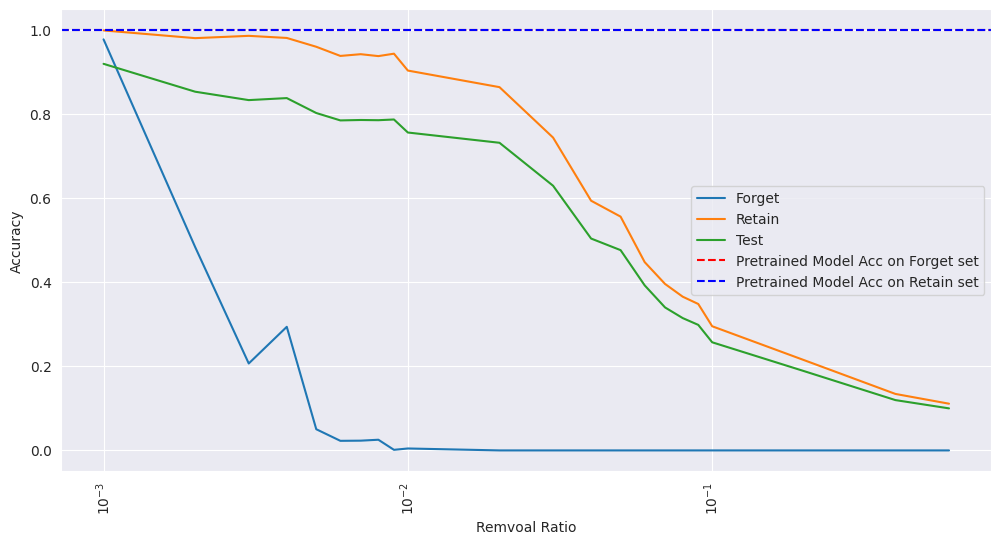

In [ ]:
R_=[round(i,3) for i in R]
plt.figure(figsize=(12,6))
df =pd.DataFrame(r_perf)
df.index=[ i for i in R_]
df.columns=['Forget','Retain','Test']
sns.lineplot(data=df,dashes=False)
sns.set_style("darkgrid")
plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel('Remvoal Ratio')
plt.ylabel('Accuracy')
plt.axhline(y=original_forget_perf, color='red', linestyle='--', label='Pretrained Model Acc on Forget set')
plt.axhline(y=original_forget_perf, color='blue', linestyle='--', label='Pretrained Model Acc on Retain set')
plt.legend(loc='center right')

plt.show()

### Let's pick the Removal Ratio = 0.01

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
torch.cuda.empty_cache()
unlearner = Unlearner_FM(0.01,model, lr = 1e-5)
    ### Getting the new model masked model

new_model, mask_index,num_of_param=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_path,retain_path)
new_model,epoch_log=unlearner.fine_tune(new_model,retain_dataloader,10)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:32944, Number of masked Paramters:329


100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


In [ ]:
log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n
unlearn_history

phase  epoch     tp      n      loss  accuracy
0  Fine-tuning      0  42845  45000  0.146955  0.952111
1  Fine-tuning      1  43955  45000  0.073461  0.976778
2  Fine-tuning      2  44370  45000  0.046635  0.986000
3  Fine-tuning      3  44638  45000  0.032740  0.991956
4  Fine-tuning      4  44743  45000  0.025949  0.994289
5  Fine-tuning      5  44835  45000  0.021511  0.996333
6  Fine-tuning      6  44881  45000  0.018616  0.997356
7  Fine-tuning      7  44904  45000  0.017458  0.997867
8  Fine-tuning      8  44943  45000  0.015286  0.998733
9  Fine-tuning      9  44945  45000  0.014901  0.998778

In [ ]:
finetune_FM_forget_perf=Unlearner_FM.test(new_model,forget_dataloader,'cuda')
finetune_FM_retain_perf=Unlearner_FM.test(new_model,retain_dataloader,'cuda')
finetune_FM_test_perf=Unlearner_FM.test(new_model,testloader,'cuda')


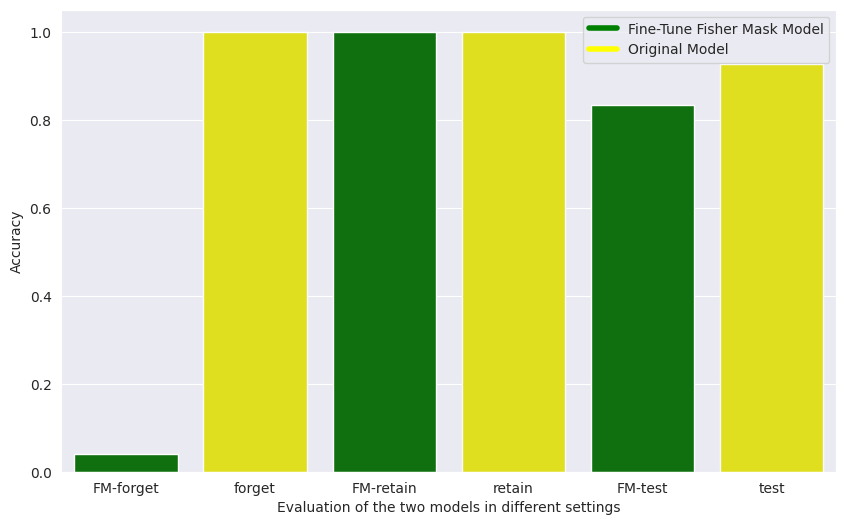

In [ ]:
plt.figure(figsize=(10,6))
bar_result = [finetune_FM_forget_perf, original_forget_perf, finetune_FM_retain_perf, original_retain_perf, finetune_FM_test_perf, original_test_perf]

df = pd.DataFrame({'values': bar_result})
df.index = ['FM-forget', 'forget', 'FM-retain', 'retain', 'FM-test', 'test']

# Create a list of custom colors for alternate bars
colors = ['green', 'yellow'] * (len(df) // 2)

# Create a barplot using Seaborn and assign the custom colors
ax = sns.barplot(data=df, x=df.index, y='values', palette=colors)

plt.xlabel('Evaluation of the two models in different settings')
plt.ylabel('Accuracy')
# Create a legend with the correct colors
legend_labels = ['Fine-Tune Fisher Mask Model', 'Original Model']
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors[:2]]  # Create custom legend handles
plt.legend(handles, legend_labels, loc='best')

# Rotate the x-axis tick labels to 60 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()




### Test Dataset

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


frog frog


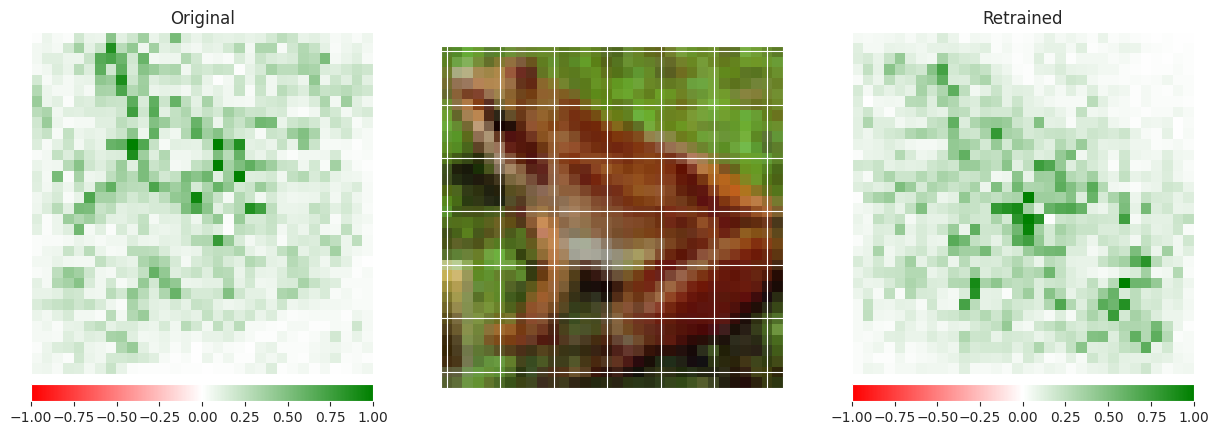

(<Figure size 1500x500 with 5 Axes>, <Axes: title={'center': 'Original'}>)

In [ ]:
# import torch
# from torchvision import models, transforms
# !pip install git+https://github.com/pytorch/captum.git
# from captum.attr import Saliency
# from captum.attr import visualization as viz
#### Test Data
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.to('cuda')


LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck',]
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = (1/0.2023, 1/0.1994, 1/0.2010)),
    transforms.Normalize(mean = (-0.4914, -0.4822, -0.4465), std = [ 1., 1., 1. ])])

saliency_og  = Saliency(model)
saliency_unl = Saliency(new_model)
new_model.to('cuda')
idx=30
for X, y in testloader:
    img = X[idx-1:idx].to(device)
    predicted_label=LABELS[torch.argmax(new_model(img),axis=1)]
    label = LABELS[y[idx-1]]
    unl_map = saliency_unl.attribute(img, target=y[idx-1])
    og_map  = saliency_og.attribute(img, target=y[idx-1])
    break


print(label,predicted_label)
img_ = inv_normalize(img).squeeze().detach().cpu().numpy().clip(0,1).transpose((1, 2, 0))
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[1].imshow(img_)
ax[1].xaxis.set_ticks_position("none")
ax[1].yaxis.set_ticks_position("none")
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
viz.visualize_image_attr(
    unl_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[2]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, use_pyplot=False,
    title='Retrained')
viz.visualize_image_attr(
    og_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[0]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, title='Original')

### Forget

automobile truck


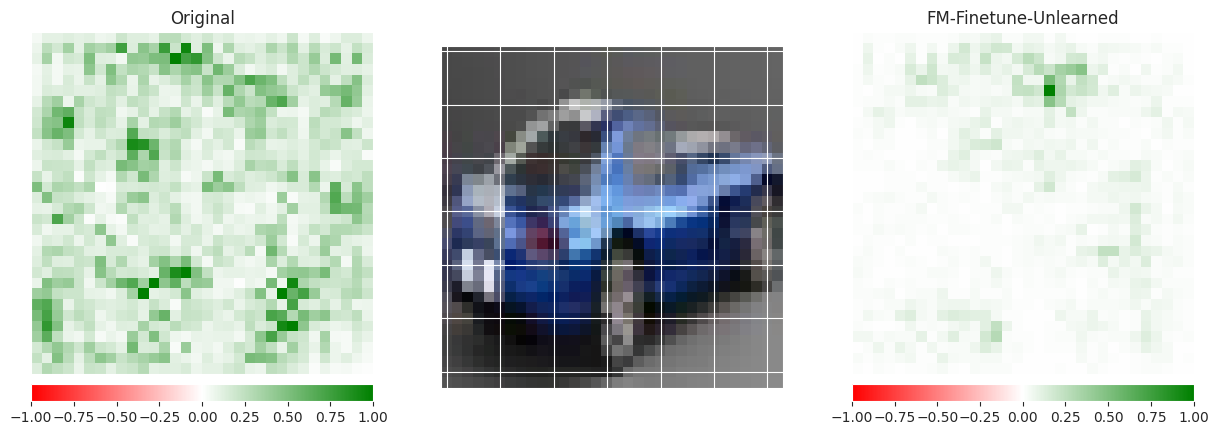

(<Figure size 1500x500 with 5 Axes>, <Axes: title={'center': 'Original'}>)

In [ ]:
saliency_og  = Saliency(model)
saliency_unl = Saliency(new_model)

idx=1
for X, y in forget_dataloader:
    img = X[idx-1:idx].to(device)
    predicted_label=LABELS[torch.argmax(new_model(img),axis=1)]
    label = LABELS[y[idx-1]]
    unl_map = saliency_unl.attribute(img, target=y[idx-1])
    og_map  = saliency_og.attribute(img, target=y[idx-1])
    break

print(label,predicted_label)
img_ = inv_normalize(img).squeeze().detach().cpu().numpy().clip(0,1).transpose((1, 2, 0))
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[1].imshow(img_)
ax[1].xaxis.set_ticks_position("none")
ax[1].yaxis.set_ticks_position("none")
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
viz.visualize_image_attr(
    unl_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[2]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, use_pyplot=False,
    title='FM-Finetune-Unlearned')
viz.visualize_image_attr(
    og_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[0]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, title='Original')

## Retain


bird bird


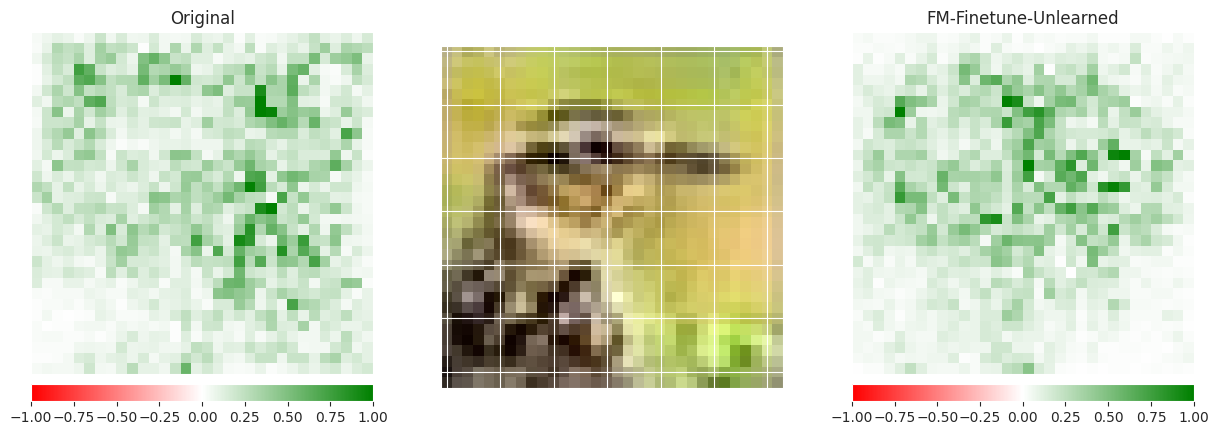

(<Figure size 1500x500 with 5 Axes>, <Axes: title={'center': 'Original'}>)

In [ ]:
saliency_og  = Saliency(model)
saliency_unl = Saliency(new_model)

idx=1
for X, y in retain_dataloader:
    img = X[idx-1:idx].to(device)
    predicted_label=LABELS[torch.argmax(new_model(img),axis=1)]
    label = LABELS[y[idx-1]]
    unl_map = saliency_unl.attribute(img, target=y[idx-1])
    og_map  = saliency_og.attribute(img, target=y[idx-1])
    break

print(label,predicted_label)
img_ = inv_normalize(img).squeeze().detach().cpu().numpy().clip(0,1).transpose((1, 2, 0))
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[1].imshow(img_)
ax[1].xaxis.set_ticks_position("none")
ax[1].yaxis.set_ticks_position("none")
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
viz.visualize_image_attr(
    unl_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[2]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, use_pyplot=False,
    title='FM-Finetune-Unlearned')
viz.visualize_image_attr(
    og_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = img_, plt_fig_axis=(fig,ax[0]),
    method="heat_map", sign="all", show_colorbar=True, alpha_overlay=0.4, title='Original')

### Random Samples Unlearning

In [34]:
torch.manual_seed(420)
num_retain_samples=int(0.95* len(train_dataset))
random_idx=torch.randperm(len(train_dataset))
indices_retain=random_idx[:num_retain_samples]
indices_forget=random_idx[num_retain_samples::]
print(indices_forget)
retain_dataset=torch.utils.data.Subset(train_dataset,indices=indices_retain)
forget_dataset=torch.utils.data.Subset(train_dataset,indices=indices_forget)
retain_dataloader = torch.utils.data.DataLoader(retain_dataset, batch_size=256, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(forget_dataset, batch_size=256, shuffle=True, num_workers=2)

tensor([49101, 10855, 22189,  ..., 30806, 44809, 42389])


In [35]:
### Congiguration file taken
config={'max_epochs': 200,

                     'data':
                      [('type_', 'cifar100'),
                                  ('image_size', 32),
                                  ('num_classes', 100),
                                  ('root', 'data/cifar100'),
                                  ('mean', [0.4914, 0.4822, 0.4465]),
                                  ('std', [0.2673, 0.2564, 0.2761]),
                                  ('batch_size', 256),
                                  ('num_workers', 4)],
                     'model':[('type_', 'PyTorchHub'),
                                  ('force_reload', False),
                                  ('repo', 'chenyaofo/pytorch-cifar-models'),
                                  ('name', 'cifar100_vgg11_bn'),
                                  ('pretrained', False)],
                     'optimizer':
                      [('type_', 'SGD'),
                                  ('lr', 0.1),
                                  ('momentum', 0.9),
                                  ('dampening', 0),
                                  ('weight_decay', 0.0005),
                                  ('nesterov', True)],
                     'scheduler':
                      [('type_', 'CosineAnnealingLR'),
                                  ('T_max', 200),
                                  ('eta_min', 0)],
                     }

In [7]:
def init_weights(layer: Module) -> None:
        """
        reset_parameters = getattr(layer, "reset_parameters", None)
        if callable(reset_parameters):
            layer.reset_parameters()
        if isinstance(layer, nn.BatchNorm2d):
            # Reset BatchNorm parameters (gamma and beta)
            nn.init.ones_(layer.weight)  # Adjust 'a' and 'b' as needed
            nn.init.zeros_(layer.bias)
            # Reset BatchNorm running statistics (mean and variance)
            layer.reset_running_stats()
            return

        if hasattr(layer, 'bias') and layer.bias is not None:
            nn.init.zeros_(layer.bias)
        if hasattr(layer, 'weight'):
            nn.init.xavier_normal_(layer.weight, 1)
        """
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.BatchNorm2d):
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, 0, 0.01)

In [8]:
def reset_weights(model: Module,device='cuda') -> Module:
        dumb_model = deepcopy(model)
        dumb_model = dumb_model.apply(init_weights)
        return dumb_model.to(device)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
def train_model(model:Module,train_dataloader,test_dataloader,config:dict,device:str):

    # model=reset_weights(model)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1,weight_decay=5e-4,momentum=config['optimizer'][2][1],dampening=config['optimizer'][3][1],nesterov=True)
    ### intialiasing the scheuler
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=config['scheduler'][1][1],eta_min=config['scheduler'][2][1])
    ### Number of the epochs
    epochs=config['max_epochs']## Train dataloader
    ### early stopping counter
    stop_counter = 0
    ## criterion
    criterion=CrossEntropyLoss(reduction='mean')

    ### Epoch Log of losses
    epoch_log=[]


    ###Iterations
    for epoch in tq(range(epochs)):
        ### iterate over the forget_dataloader
        ### batch _loss
        loss_epoch = 0

        acc_epoch=0
        n_epoch=0
        model.train()

        for i, (inputs, targets) in enumerate(train_dataloader):


            ### GPU push
            inputs, targets = inputs.to(
                device), targets.to(device)

            if next(model.parameters()).is_cuda:
                    pass
                    # print("Model is on CUDA (GPU)")
            else:
                    model=model.to(device)


            ### predictions from the model
            y_pred = model(inputs)

            optimizer.zero_grad()

            ###Calculate the Loss

            loss = criterion(y_pred, targets)

            ## Backpropogate the Loss
            loss.backward()
            ### Update the weights
            optimizer.step()

            #### Train-set loss
            loss_epoch += loss.item()

            ### Number of correct samples
            acc_epoch+=(y_pred.argmax(axis=1) == targets).sum().item()
            n_epoch+=targets.size(0)

        loss_epoch /= (i + 1)
        acc_epoch /=n_epoch

        test_acc_epoch=test(model,test_dataloader,'cuda')


        # ### Check for early stopping: if the decrease in the loss is less than 1e-3 for straight 5 iterations

        # if epoch > 0:
        #     if abs(epoch_log[-1][0] - loss_epoch) < 1e-3:

        #         print('increaing the counter',epoch_log[-1][0] - loss_epoch)
        #         stop_counter += 1

        #     else:
        #         stop_counter = 0

        epoch_log.append([loss_epoch,acc_epoch,test_acc_epoch])
        # print(loss_epoch)
        if epoch%5==0:
          print(epoch_log[-1])
          sns.lineplot(pd.DataFrame(epoch_log).iloc[:,0])
          plt.show()
        if loss_epoch<1e-2:
          break


    return model,epoch_log


In [37]:

def test(model, dataloader,device):
        model.eval()
        tp, n = 0,0
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)

            with torch.no_grad():
                y_pred = model(X)

            tp += (y_pred.argmax(axis=1) == y).sum().item()
            n  += y.size(0)

        return tp/n


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
  0%|          | 0/200 [00:00<?, ?it/s]

[1.4624131728884995, 0.45648421052631577, 0.4514]


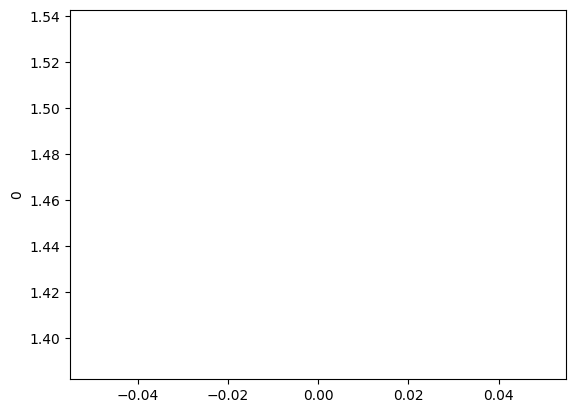

  2%|▎         | 5/200 [01:46<1:08:48, 21.17s/it]

[0.474449416963003, 0.8355789473684211, 0.7376]


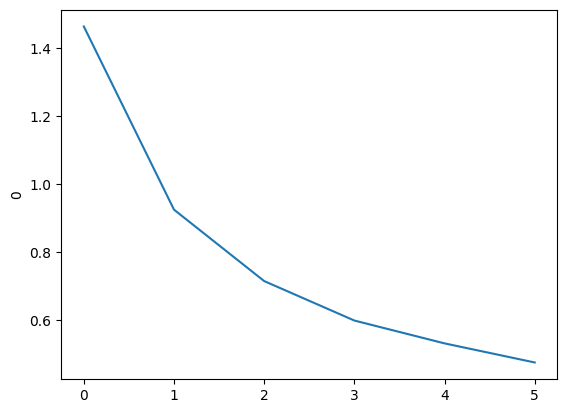

  5%|▌         | 10/200 [03:26<1:04:42, 20.43s/it]

[0.33552145645503073, 0.8825684210526316, 0.6983]


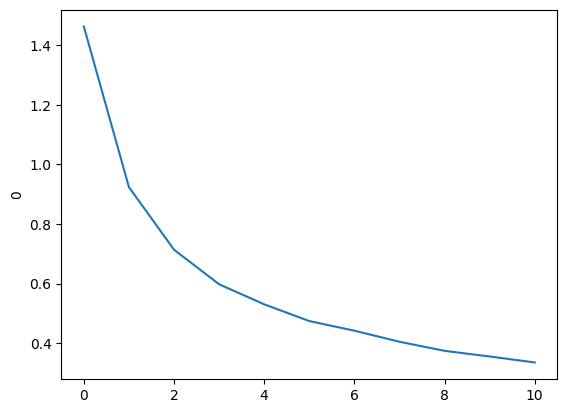

  8%|▊         | 15/200 [05:08<1:02:26, 20.25s/it]

[0.27435157568224017, 0.9042526315789474, 0.7607]


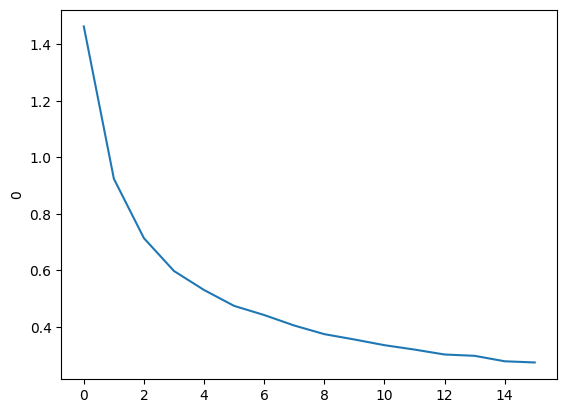

 10%|█         | 20/200 [06:47<59:52, 19.96s/it]

[0.22747099988402858, 0.9208842105263157, 0.7925]


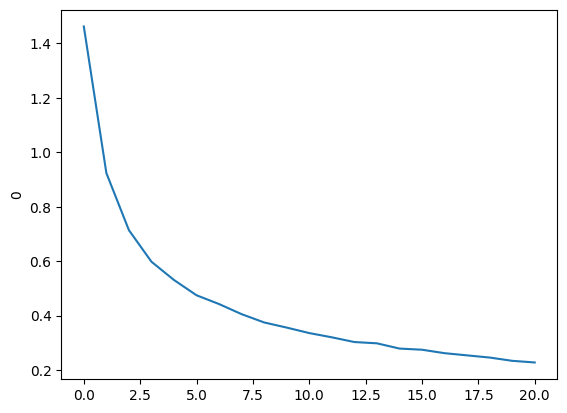

 12%|█▎        | 25/200 [08:29<59:40, 20.46s/it]

[0.20538130046058728, 0.9286315789473685, 0.7653]


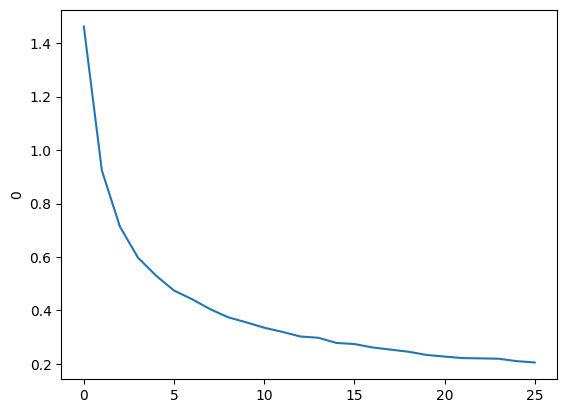

 15%|█▌        | 30/200 [10:08<57:05, 20.15s/it]

[0.19574636789739772, 0.9303789473684211, 0.7873]


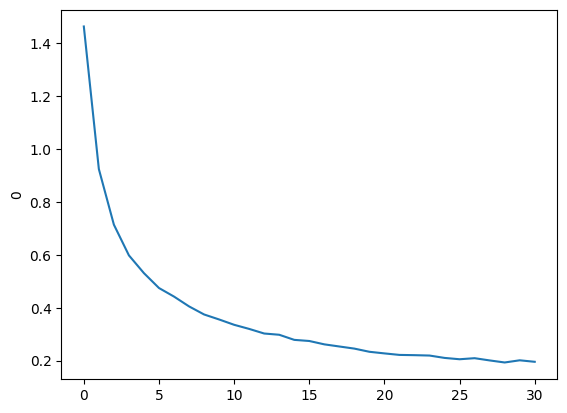

 18%|█▊        | 35/200 [11:48<55:19, 20.12s/it]

[0.18058400320750412, 0.9355368421052631, 0.7884]


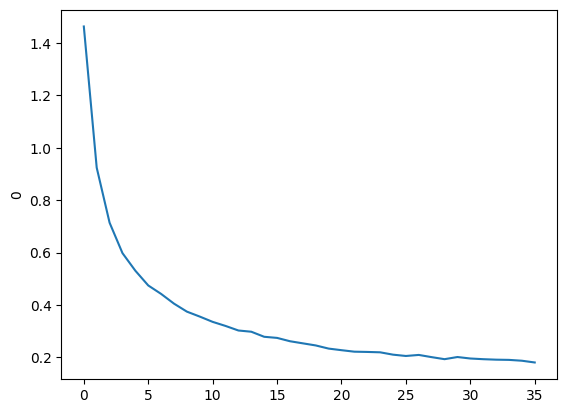

 20%|██        | 40/200 [13:31<54:11, 20.32s/it]

[0.18330806253417845, 0.936021052631579, 0.7198]


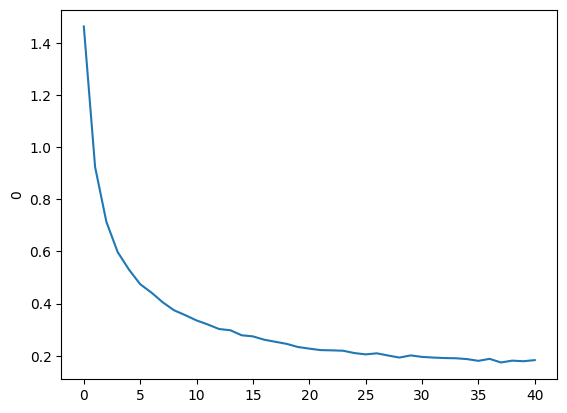

 22%|██▎       | 45/200 [15:10<51:03, 19.76s/it]

[0.17799993131750375, 0.9382736842105264, 0.774]


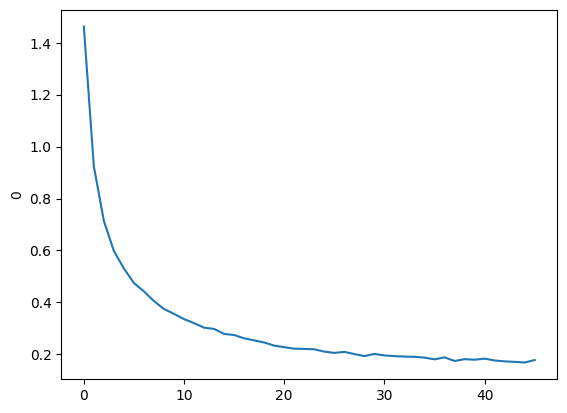

 25%|██▌       | 50/200 [16:47<48:26, 19.37s/it]

[0.16510827619061674, 0.9429263157894737, 0.7312]


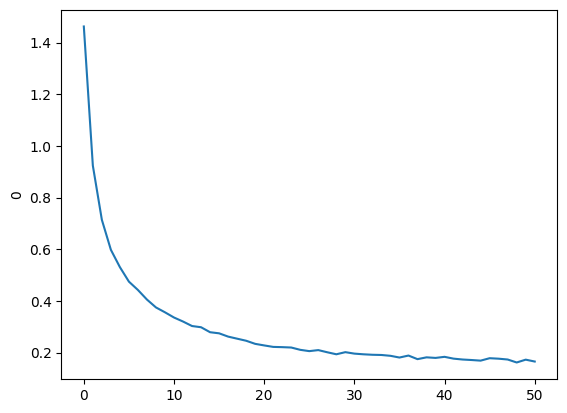

 28%|██▊       | 55/200 [18:24<46:51, 19.39s/it]

[0.16884384632751506, 0.9400842105263157, 0.7864]


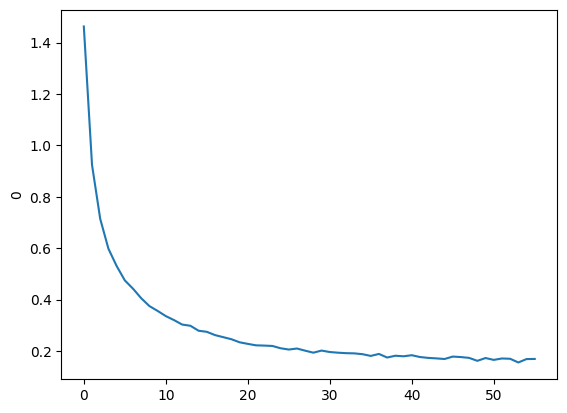

 30%|███       | 60/200 [19:59<44:29, 19.07s/it]

[0.16488284601639674, 0.9426736842105263, 0.7512]


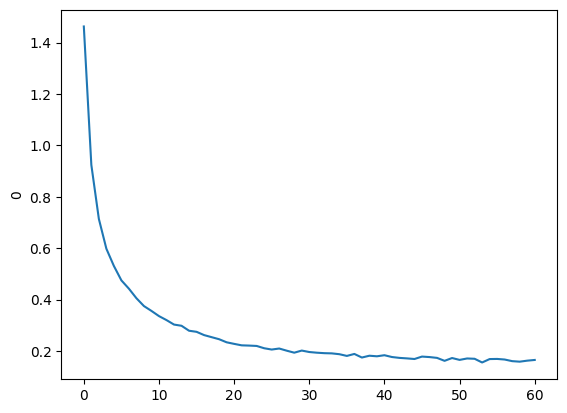

 32%|███▎      | 65/200 [21:35<43:26, 19.31s/it]

[0.1557906713456877, 0.9460842105263157, 0.7176]


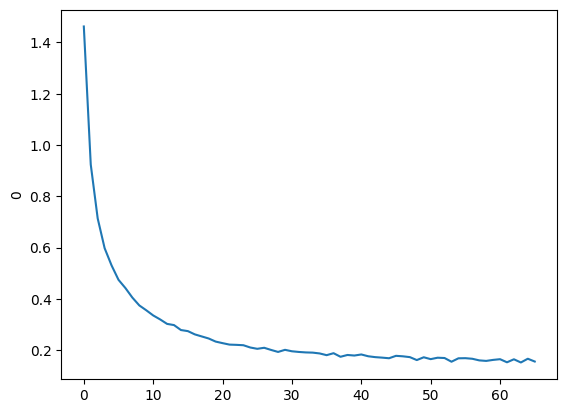

 35%|███▌      | 70/200 [23:11<41:08, 18.98s/it]

[0.154861391191521, 0.9467578947368421, 0.7671]


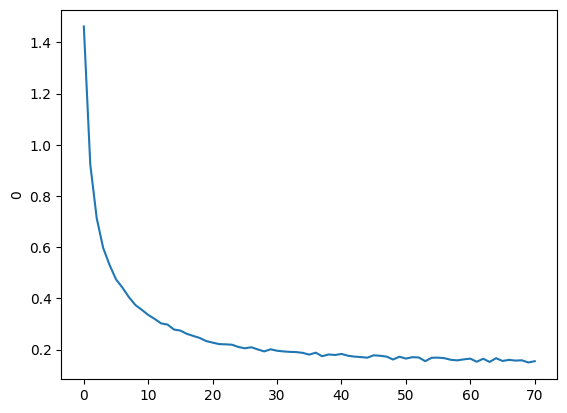

 38%|███▊      | 75/200 [24:46<39:46, 19.09s/it]

[0.150171128331974, 0.9478736842105263, 0.7553]


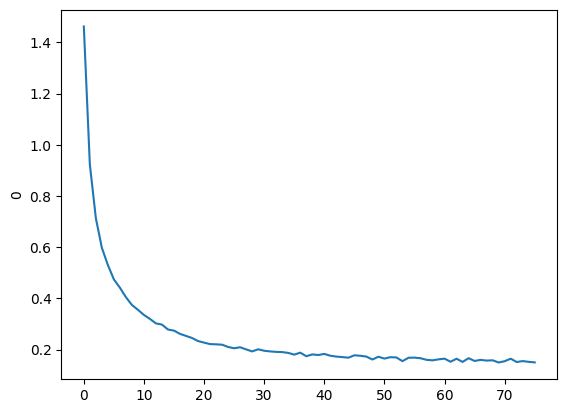

 40%|████      | 80/200 [26:22<38:23, 19.20s/it]

[0.14858204811330764, 0.9472, 0.7708]


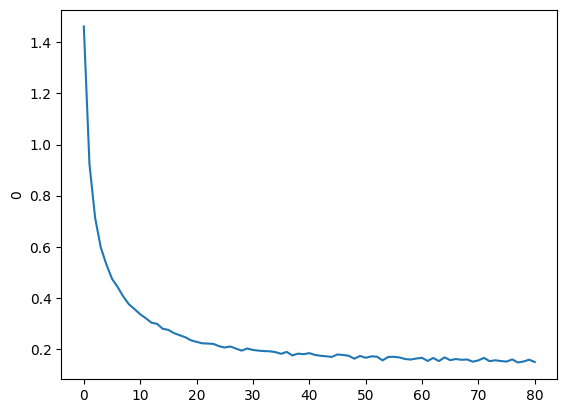

 42%|████▎     | 85/200 [27:57<36:13, 18.90s/it]

[0.1477703705670372, 0.9491368421052632, 0.7214]


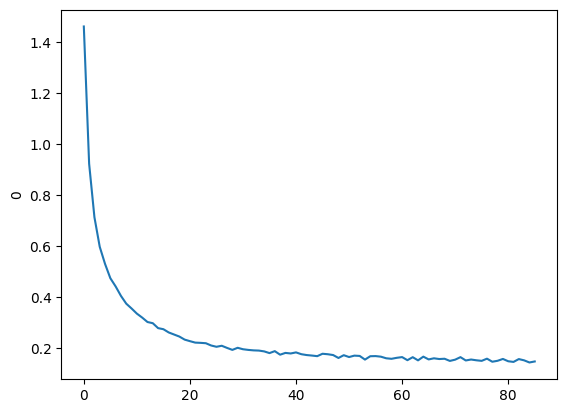

 45%|████▌     | 90/200 [29:33<34:47, 18.98s/it]

[0.1521417939614865, 0.9464210526315789, 0.796]


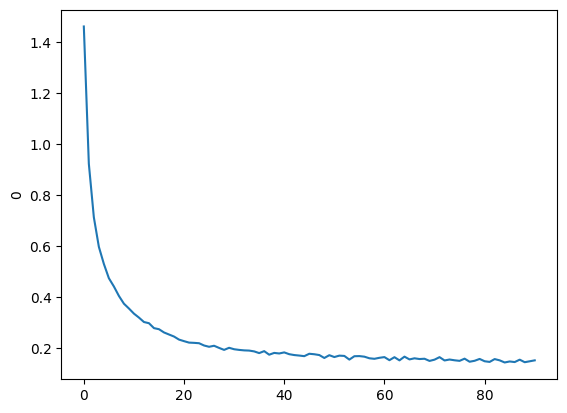

 46%|████▌     | 92/200 [30:13<35:38, 19.80s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19ba2827a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19ba2827a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f19ba2827a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()
  File "/usr/

[0.14489427309042663, 0.9497473684210527, 0.7339]


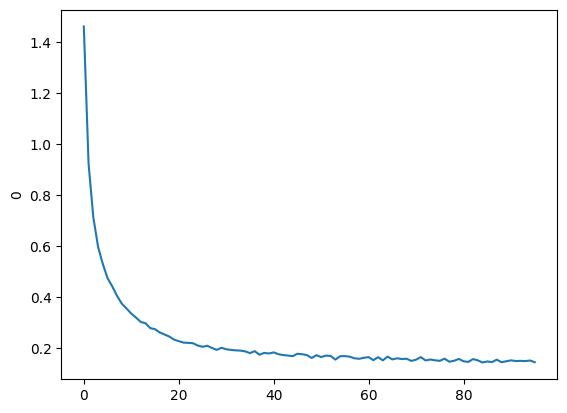

 50%|█████     | 100/200 [32:49<32:29, 19.49s/it]

[0.14570755251152542, 0.9490736842105263, 0.777]


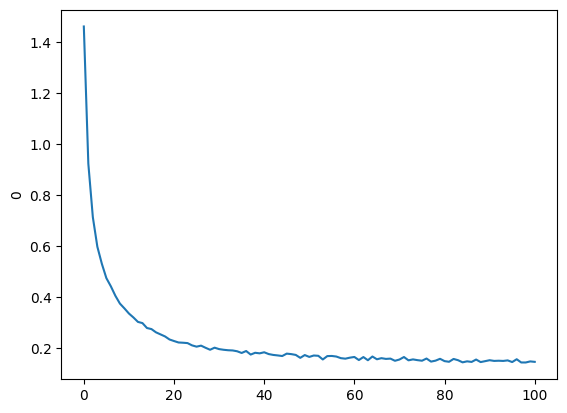

 52%|█████▎    | 105/200 [34:29<32:06, 20.28s/it]

[0.14322870084515182, 0.9498315789473685, 0.7362]


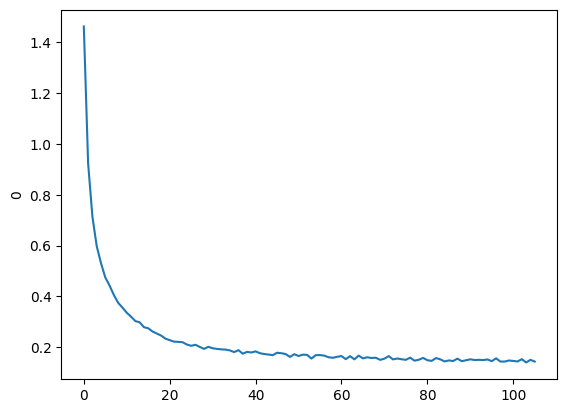

 55%|█████▌    | 110/200 [36:07<29:48, 19.87s/it]

[0.14854666963219643, 0.9476631578947369, 0.7811]


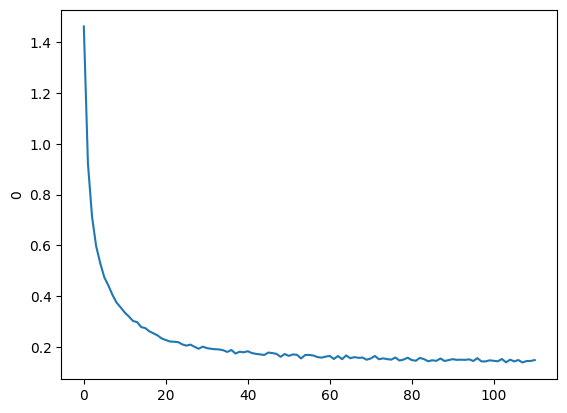

 57%|█████▊    | 115/200 [37:44<27:40, 19.54s/it]

[0.14217928104022498, 0.9511368421052632, 0.7662]


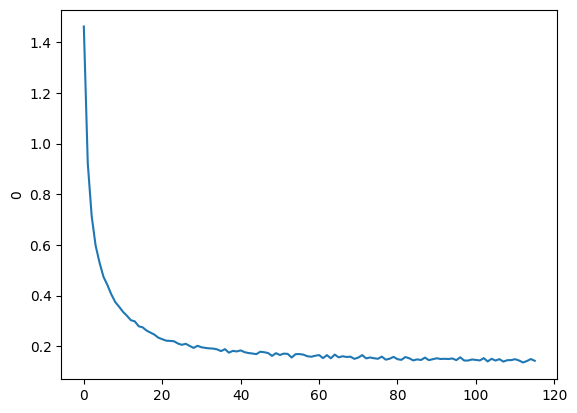

 60%|██████    | 120/200 [39:25<26:56, 20.21s/it]

[0.13925440639497771, 0.9529052631578947, 0.7923]


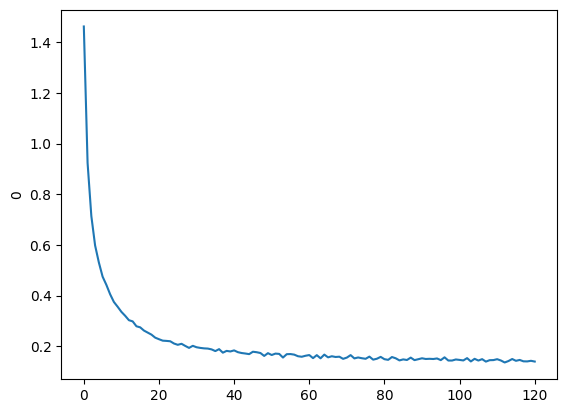

 62%|██████▎   | 125/200 [41:05<25:09, 20.13s/it]

[0.13755231593004477, 0.9523368421052631, 0.7083]


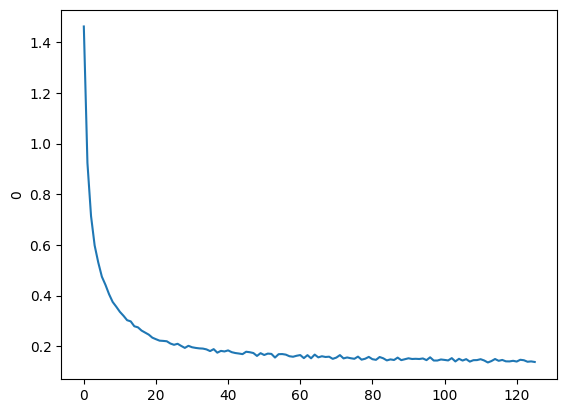

 65%|██████▌   | 130/200 [42:43<23:06, 19.81s/it]

[0.13974544562159047, 0.9494736842105264, 0.7655]


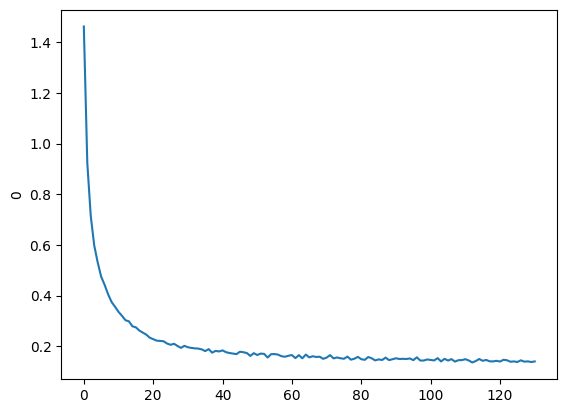

 68%|██████▊   | 135/200 [44:22<21:26, 19.79s/it]

[0.14000015505539473, 0.951978947368421, 0.7994]


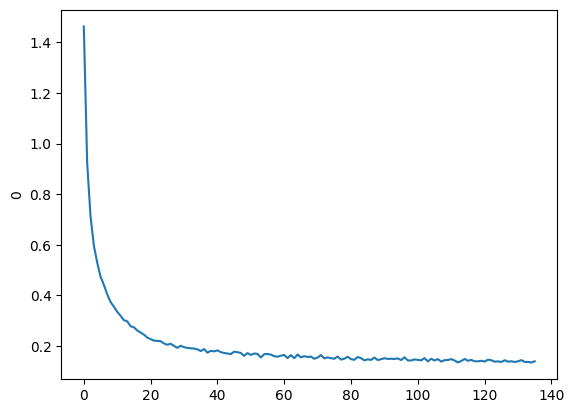

 70%|███████   | 140/200 [46:08<20:18, 20.31s/it]

[0.14236767409789947, 0.9510315789473685, 0.797]


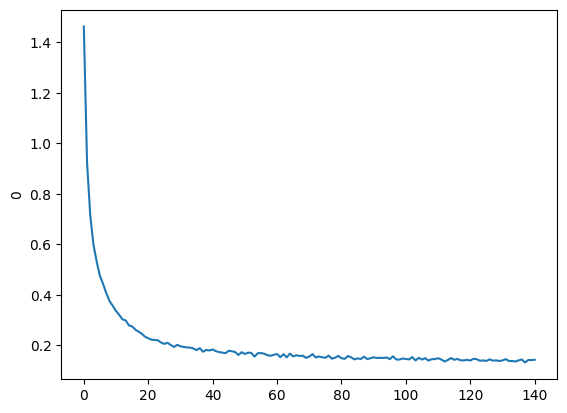

 72%|███████▎  | 145/200 [47:47<18:00, 19.64s/it]

[0.14274008111447417, 0.9501052631578948, 0.7944]


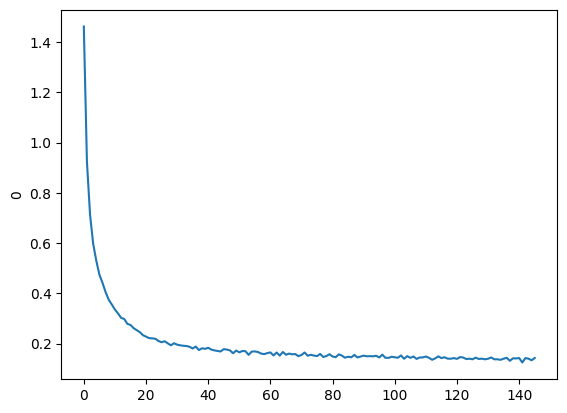

 75%|███████▌  | 150/200 [49:24<16:09, 19.39s/it]

[0.1358215328185789, 0.9534947368421053, 0.7916]


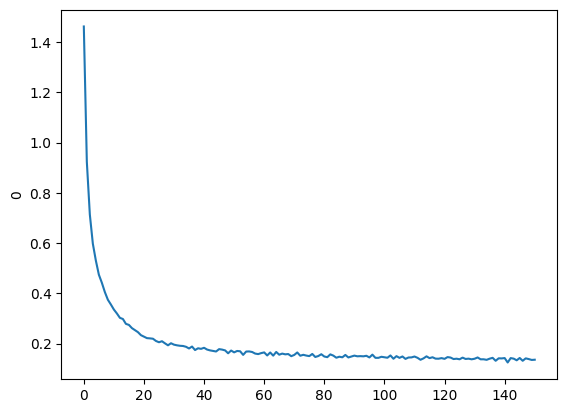

 78%|███████▊  | 155/200 [51:04<15:05, 20.13s/it]

[0.1394932126245832, 0.9500631578947368, 0.7467]


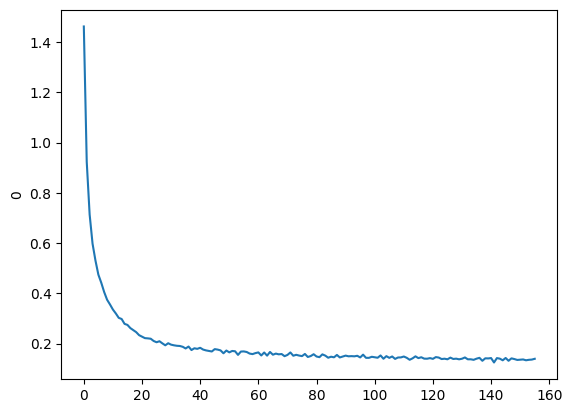

 78%|███████▊  | 156/200 [51:31<16:23, 22.36s/it]

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=False)
model.to('cuda')
retrained_model,epoch_log=train_model(model,retain_dataloader,testloader,config,'cuda')

In [ ]:
torch.save(retrained_model,'resnet20_retrain_random_samples_3.pt')
from shutil import copyfile
copyfile('resnet20_retrain_random_samples_3.pt', '/content/drive/My Drive/resnet20_retrain_random_samples_3.pt')

_1 same setting of LR as original with 10% forget dataset and SGD
_2 same setting of LR as original with 5% rforget dataset and SGD
_3 same setting of LR as original with 5% rforget dataset and Adam

In [ ]:
def JS_divergence(model,retraindataloader):

        model.eval()
        tp, n = 0,0
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)

            with torch.no_grad():
                y_pred = model(X)

            tp += (y_pred.argmax(axis=1) == y).sum().item()
            n  += y.size(0)

        return tp/n



In [33]:
retrain_forget_perf=test(retrained_model,forget_dataloader,'cuda')
retrain_retain_perf=test(retrained_model,retain_dataloader,'cuda')
retrain_test_perf=test(retrained_model,testloader,'cuda')
print(retrain_forget_perf,retrain_retain_perf,retrain_test_perf)

0.7868 0.9153333333333333 0.7929


In [ ]:
epoch_log

[[2.3549210090528834, 0.10131111111111112],
 [2.317039126699621, 0.09908888888888889],
 [2.318253332241015, 0.09882222222222223],
 [2.3197051259604367, 0.10028888888888889],
 [2.3185818540779026, 0.09864444444444445],
 [2.3194385435093534, 0.1018],
 [2.3185691047798502, 0.09937777777777777],
 [2.318670787594535, 0.09968888888888888],
 [2.318598559634252, 0.10115555555555555],
 [2.3195710012858566, 0.10084444444444444]]

### Create the Syntheic Dataset
> ### There is parameter equivalent to Noise which informs me about the percentage of the samples whose labels would be randomly generated

In [ ]:

# Define the percentage of samples to shuffle labels
shuffle_percentage = 0.2  # Change this value as needed

# Calculate the number of samples to shuffle
num_samples_to_shuffle = int(shuffle_percentage * len(train_dataset))

# Create a copy of the original dataset
synthetic_dataset = deepcopy(train_dataset)

# Shuffle the labels of a subset of samples
indices_to_shuffle = torch.randperm(len(train_dataset))[:num_samples_to_shuffle]
for idx in indices_to_shuffle:
    current_label = train_dataset[idx][1]  # Get the original label
    # Choose a new label randomly (excluding the original label)
    new_label = torch.randint(0, 10, (1,)).item()
    while new_label == current_label:
        new_label = torch.randint(0, 10, (1,)).item()
    # Update the label in the synthetic dataset
    synthetic_dataset.targets[idx] = new_label



In [ ]:
### Congiguration file taken
config={'max_epochs': 200,

                     'data':
                      [('type_', 'cifar100'),
                                  ('image_size', 32),
                                  ('num_classes', 100),
                                  ('root', 'data/cifar100'),
                                  ('mean', [0.507, 0.4865, 0.4409]),
                                  ('std', [0.2673, 0.2564, 0.2761]),
                                  ('batch_size', 256),
                                  ('num_workers', 4)],
                     'model':[('type_', 'PyTorchHub'),
                                  ('force_reload', False),
                                  ('repo', 'chenyaofo/pytorch-cifar-models'),
                                  ('name', 'cifar100_vgg11_bn'),
                                  ('pretrained', False)],
                     'optimizer':
                      [('type_', 'SGD'),
                                  ('lr', 0.1),
                                  ('momentum', 0.9),
                                  ('dampening', 0),
                                  ('weight_decay', 0.0005),
                                  ('nesterov', True)],
                     'scheduler':
                      [('type_', 'CosineAnnealingLR'),
                                  ('T_max', 200),
                                  ('eta_min', 0)],
                     }

In [ ]:
def init_weights(layer: Module) -> None:
        """
        reset_parameters = getattr(layer, "reset_parameters", None)
        if callable(reset_parameters):
            layer.reset_parameters()
        if isinstance(layer, nn.BatchNorm2d):
            # Reset BatchNorm parameters (gamma and beta)
            nn.init.ones_(layer.weight)  # Adjust 'a' and 'b' as needed
            nn.init.zeros_(layer.bias)
            # Reset BatchNorm running statistics (mean and variance)
            layer.reset_running_stats()
            return

        if hasattr(layer, 'bias') and layer.bias is not None:
            nn.init.zeros_(layer.bias)
        if hasattr(layer, 'weight'):
            nn.init.xavier_normal_(layer.weight, 1)
        """
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.BatchNorm2d):
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, 0, 0.01)

In [ ]:
def reset_weights(model: Module,device='cuda') -> Module:
        dumb_model = deepcopy(model)
        dumb_model = dumb_model.apply(init_weights)
        return dumb_model.to(device)

In [ ]:
def train_VGG(model:Module,train_dataset:Dataset,config:dict,device:str):

    model=reset_weights(model)
    ### intialising the optimiser
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2,weight_decay=0.001) #torch.optim.SGD(model.parameters(), lr=config['optimizer'][2][1],weight_decay=config['optimizer'][-2][1],momentum=config['optimizer'][2][1],dampening=config['optimizer'][3][1])
    ### intialiasing the scheuler
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=config['scheduler'][1][1],eta_min=config['scheduler'][2][1])
    ### Number of the epochs
    epochs=config['max_epochs']
    ## Train dataloader
    train_dataloader_syn=DataLoader(train_dataset, batch_size=config['data'][-2][1], shuffle=True, num_workers=2)
    ### early stopping counter
    stop_counter = 0
    ## criterion
    criterion=CrossEntropyLoss()

    ### Epoch Log of losses
    epoch_log=[]


    ###Iterations
    for epoch in tq(range(epochs)):
        ### iterate over the forget_dataloader
        ### batch _loss
        loss_epoch = 0



        for i, (inputs, targets) in enumerate(train_dataloader_syn):


            ### GPU push
            inputs, targets = inputs.to(
                device), targets.to(device)

            if next(model.parameters()).is_cuda:
                    pass
                    # print("Model is on CUDA (GPU)")
            else:
                    model=model.to(device)


            ### predictions from the model
            y_pred = model(inputs)

            optimizer.zero_grad()

            ###Calculate the Loss

            loss = criterion(y_pred, targets)

            ## Backpropogate the Loss
            loss.backward()
            ### Update the weights
            optimizer.step()

            #### Train-set loss
            loss_epoch += loss.item()

        loss_epoch /= (i + 1)

        ### Check for early stopping: if the decrease in the loss is less than 1e-3 for straight 5 iterations

        if epoch > 0:
            if abs(epoch_log[-1] - loss_epoch) < 1e-3:

                print('increaing the counter',epoch_log[-1] - loss_epoch)
                stop_counter += 1

            else:
                stop_counter = 0
        epoch_log.append(loss_epoch)
        # print(loss_epoch)
        sns.lineplot(pd.DataFrame(epoch_log))
        plt.show()
        if stop_counter == 5:

            break

    return model,epoch_log


In [ ]:
    def test(model, dataloader,device):
        tp, n = 0,0
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)

            with torch.no_grad():
                y_pred = model(X)

            tp += (y_pred.argmax(axis=1) == y).sum().item()
            n  += y.size(0)

        return tp/n

  0%|          | 0/200 [00:00<?, ?it/s]

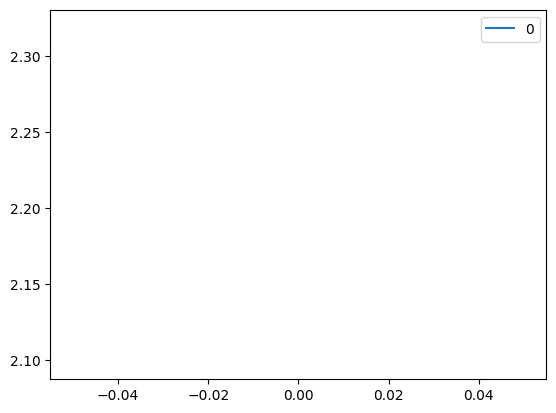

  0%|          | 1/200 [00:14<49:04, 14.80s/it]

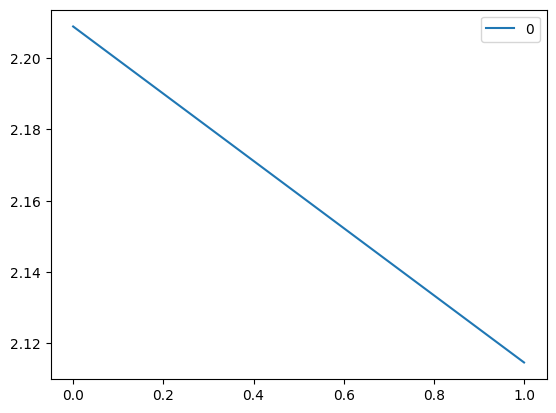

  1%|          | 2/200 [00:33<55:40, 16.87s/it]

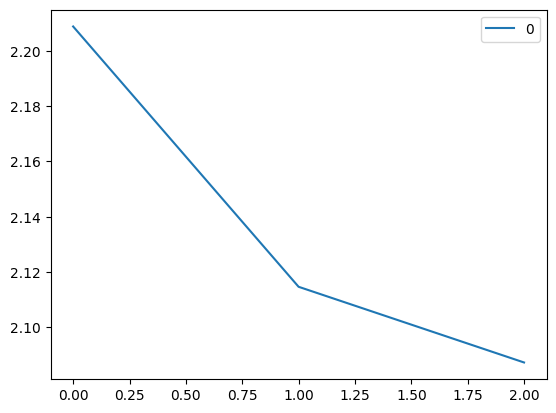

  2%|▏         | 3/200 [00:47<51:52, 15.80s/it]

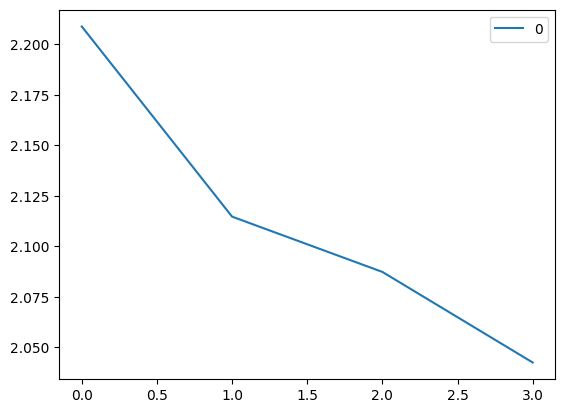

  2%|▏         | 4/200 [01:02<50:13, 15.38s/it]

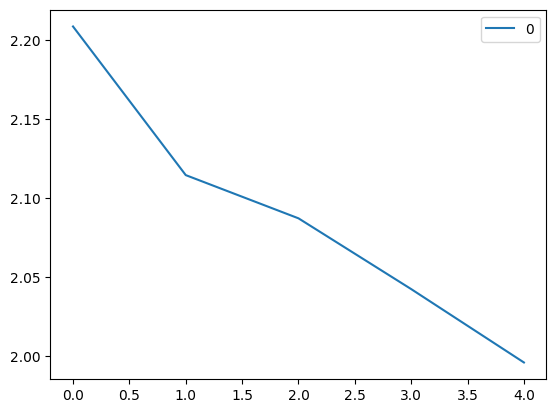

  2%|▎         | 5/200 [01:16<49:04, 15.10s/it]

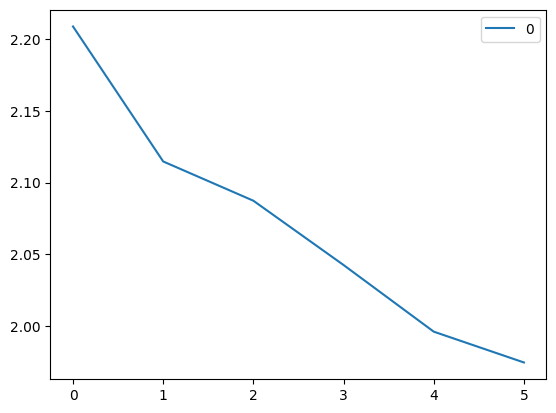

  3%|▎         | 6/200 [01:31<48:39, 15.05s/it]

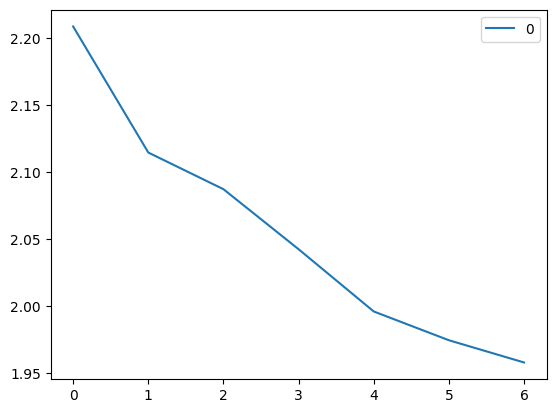

  4%|▎         | 7/200 [01:46<48:01, 14.93s/it]

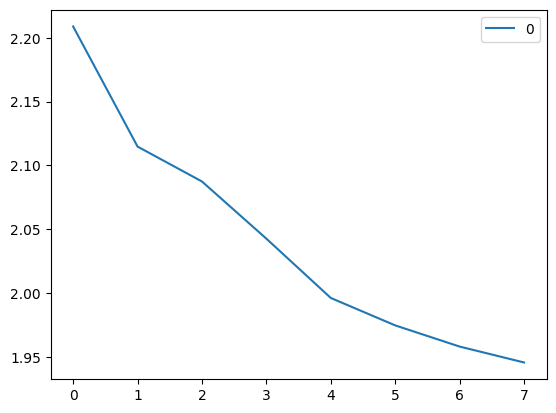

  4%|▍         | 8/200 [02:01<48:09, 15.05s/it]

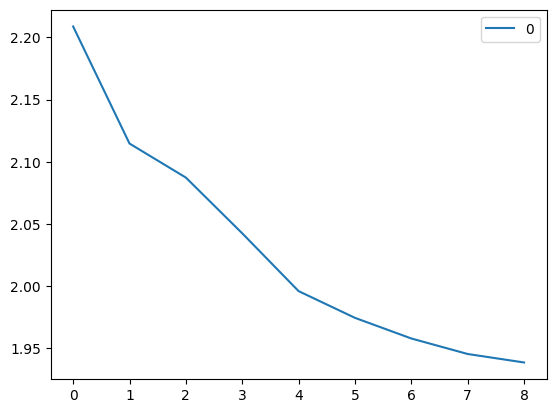

  4%|▍         | 9/200 [02:16<47:17, 14.86s/it]

increaing the counter -0.00019127312971622956


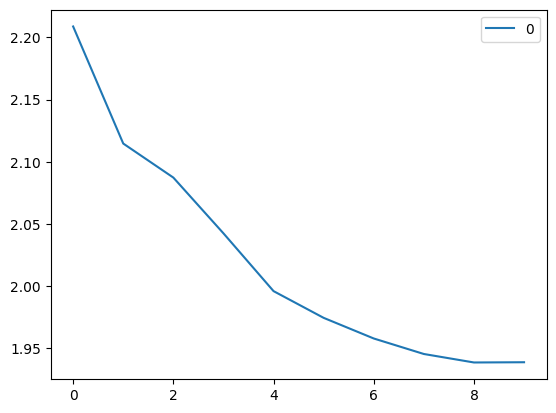

  5%|▌         | 10/200 [02:30<46:47, 14.77s/it]

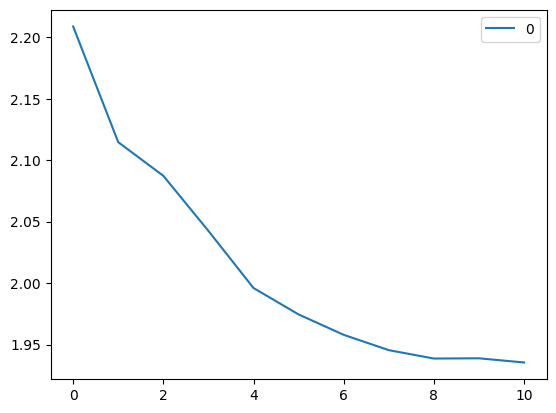

  6%|▌         | 11/200 [02:45<46:07, 14.65s/it]

increaing the counter 0.0006845927968315291


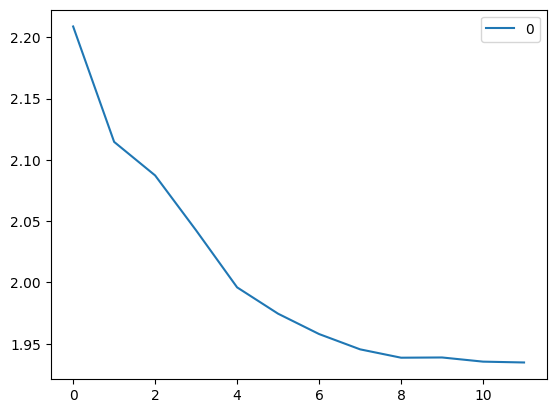

  6%|▌         | 12/200 [03:00<46:06, 14.72s/it]

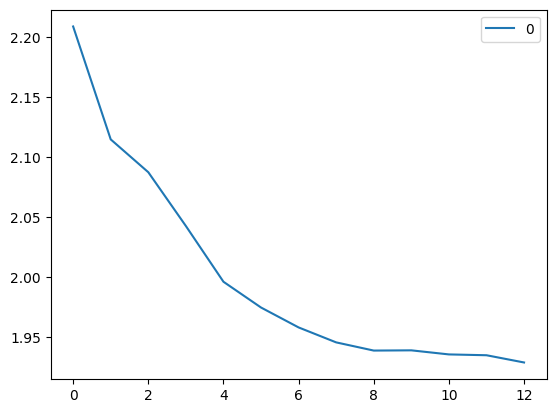

  6%|▋         | 13/200 [03:14<45:55, 14.73s/it]

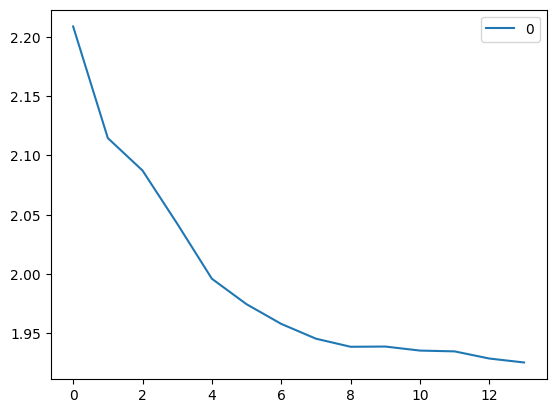

  7%|▋         | 14/200 [03:30<46:40, 15.06s/it]

increaing the counter 0.00044403331620346265


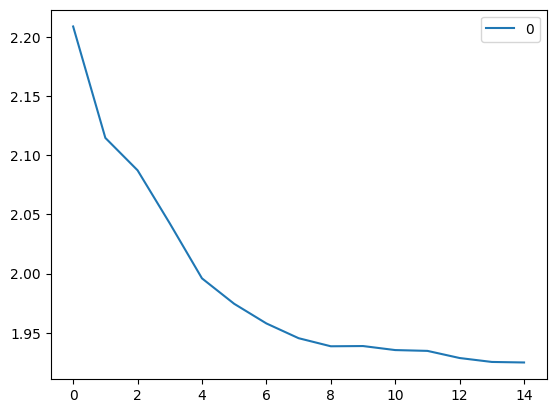

  8%|▊         | 15/200 [03:45<45:52, 14.88s/it]

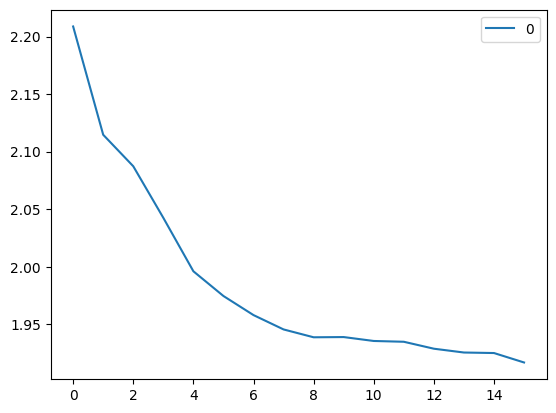

  8%|▊         | 16/200 [03:59<45:30, 14.84s/it]

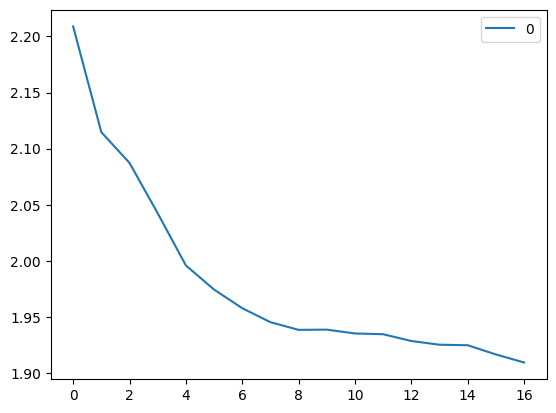

  8%|▊         | 17/200 [04:15<46:12, 15.15s/it]

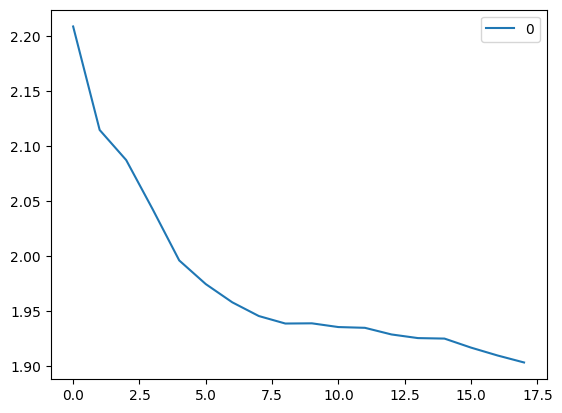

  9%|▉         | 18/200 [04:30<45:20, 14.95s/it]

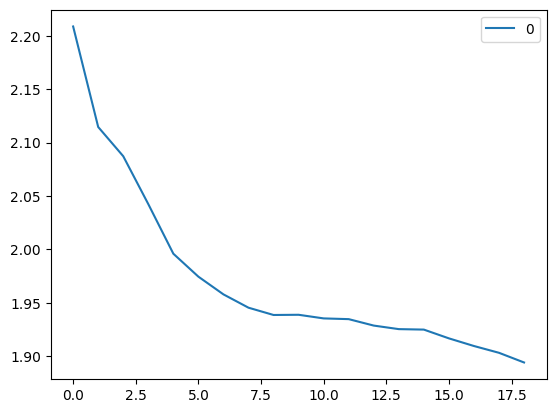

 10%|▉         | 19/200 [04:44<44:44, 14.83s/it]

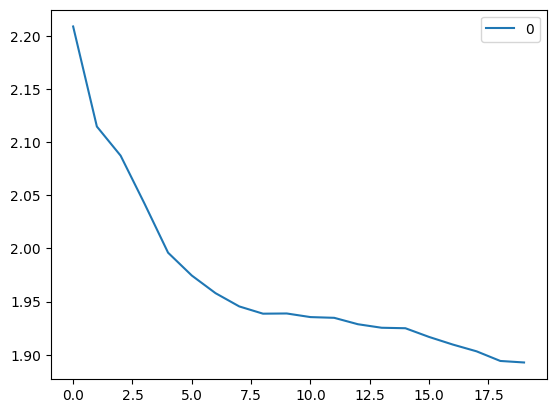

 10%|█         | 20/200 [04:59<44:03, 14.69s/it]

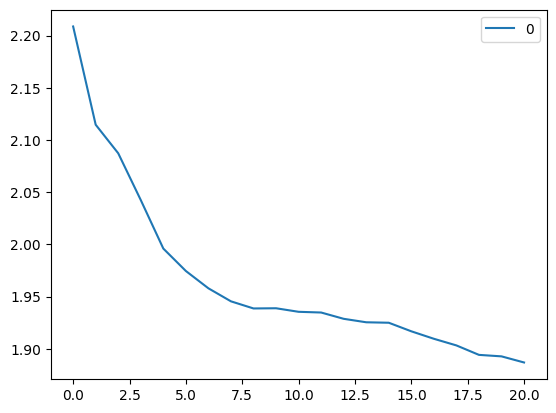

 10%|█         | 21/200 [05:14<44:29, 14.91s/it]

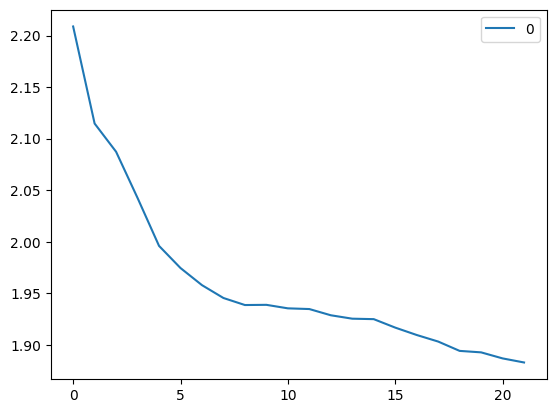

 11%|█         | 22/200 [05:29<43:56, 14.81s/it]

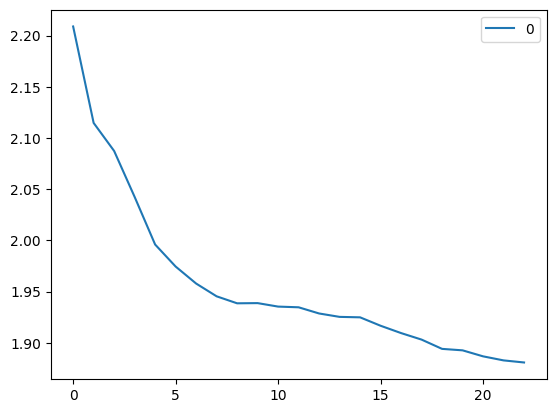

 12%|█▏        | 23/200 [05:43<43:36, 14.78s/it]

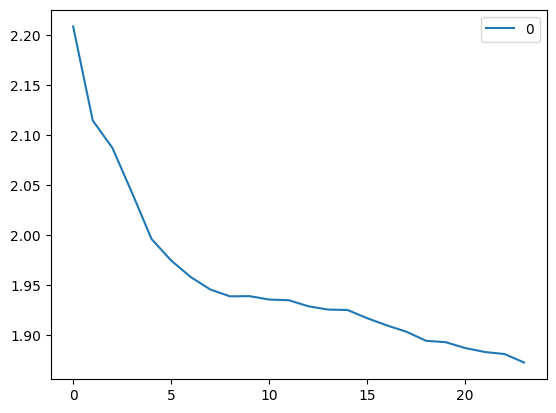

 12%|█▏        | 24/200 [05:58<43:03, 14.68s/it]

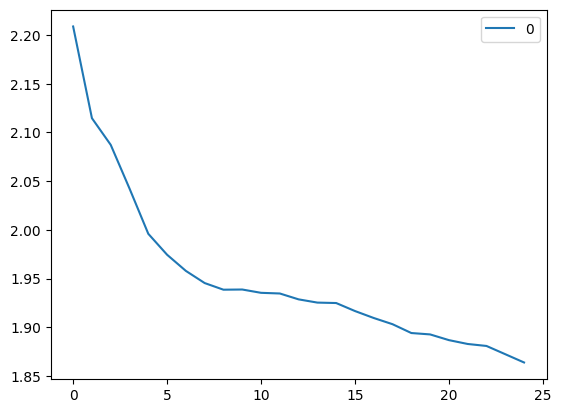

 12%|█▎        | 25/200 [06:13<42:52, 14.70s/it]

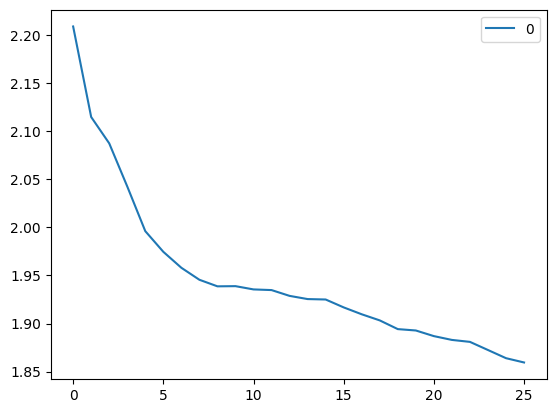

 13%|█▎        | 26/200 [06:27<42:13, 14.56s/it]

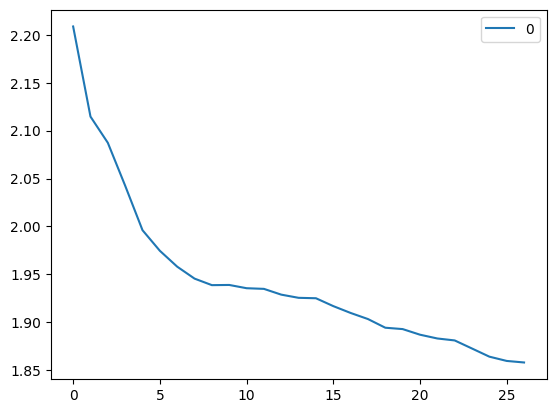

 14%|█▎        | 27/200 [06:42<42:41, 14.81s/it]

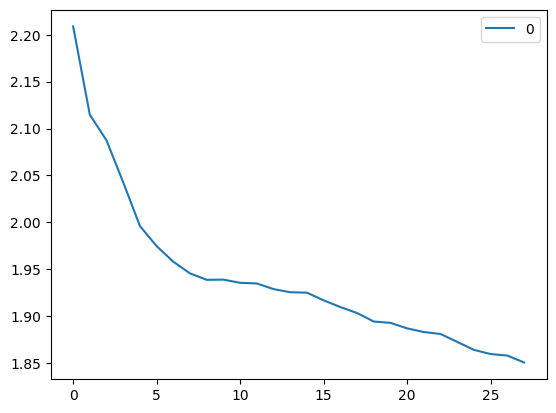

 14%|█▍        | 28/200 [06:57<42:17, 14.75s/it]

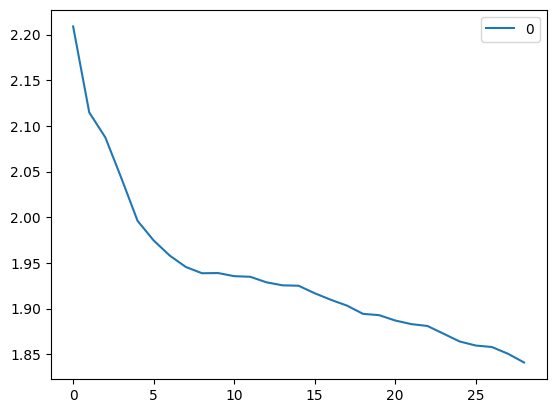

 14%|█▍        | 29/200 [07:11<41:53, 14.70s/it]

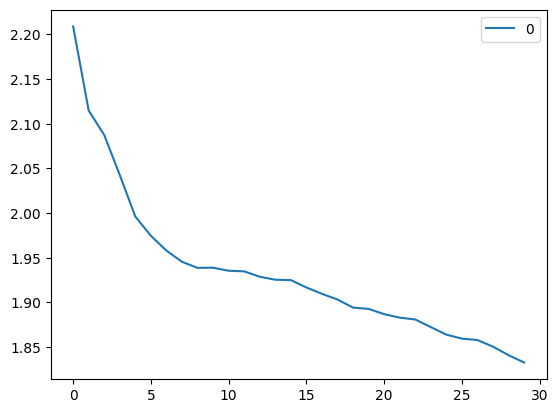

 15%|█▌        | 30/200 [07:26<41:27, 14.64s/it]

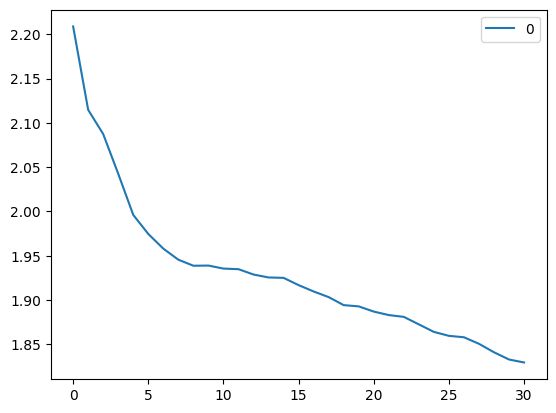

 16%|█▌        | 31/200 [07:40<41:02, 14.57s/it]

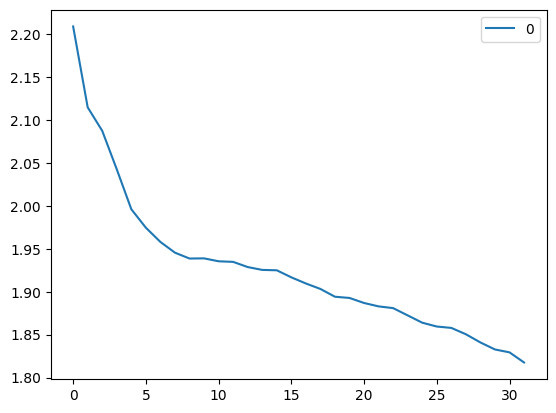

 16%|█▌        | 32/200 [07:55<40:30, 14.47s/it]

increaing the counter -0.0009632791791642781


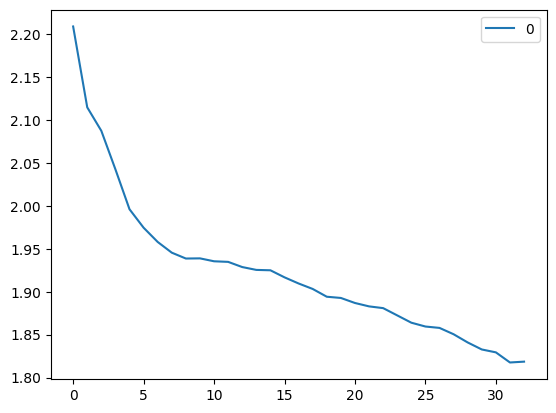

 16%|█▋        | 33/200 [08:09<40:18, 14.48s/it]

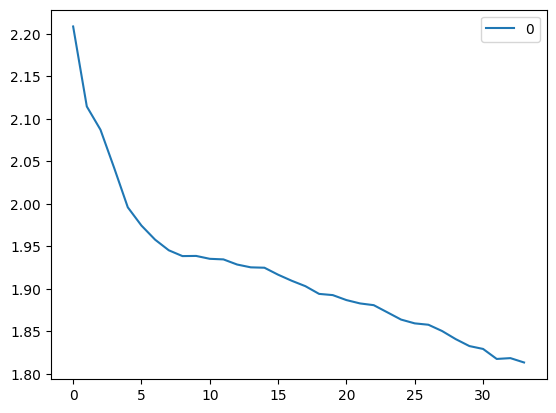

 17%|█▋        | 34/200 [08:25<41:30, 15.00s/it]

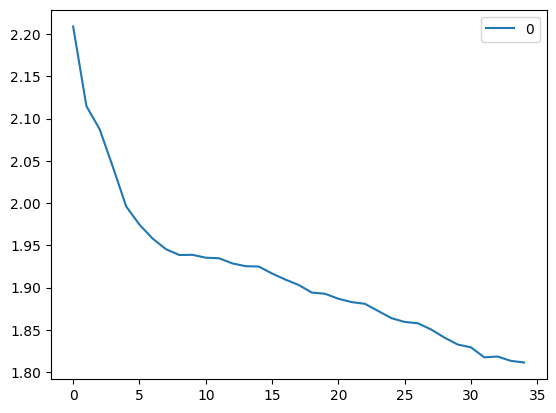

 18%|█▊        | 35/200 [08:40<40:57, 14.90s/it]

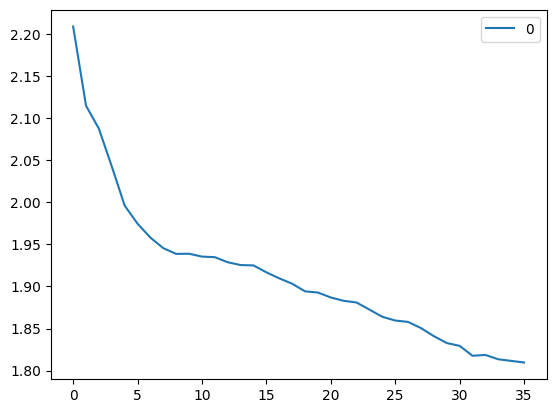

 18%|█▊        | 36/200 [08:54<40:12, 14.71s/it]

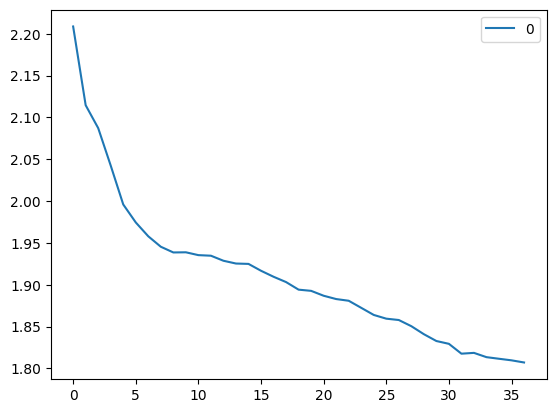

 18%|█▊        | 37/200 [09:09<39:53, 14.69s/it]

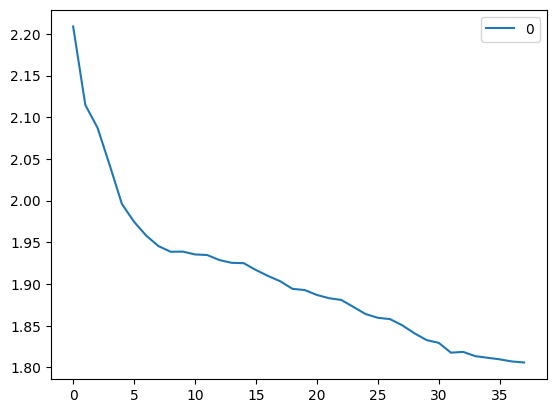

 19%|█▉        | 38/200 [09:24<39:38, 14.68s/it]

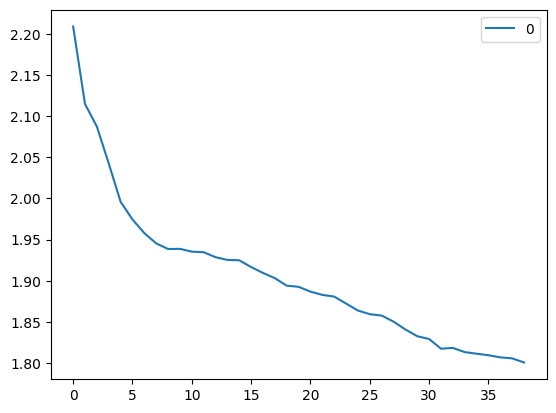

 20%|█▉        | 39/200 [09:38<39:23, 14.68s/it]

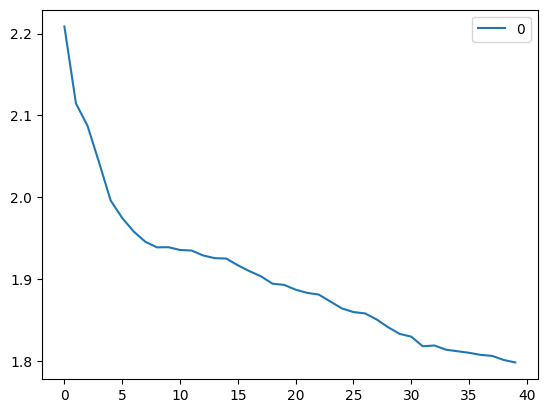

 20%|██        | 40/200 [09:53<39:36, 14.85s/it]

increaing the counter -0.00027926479067108545


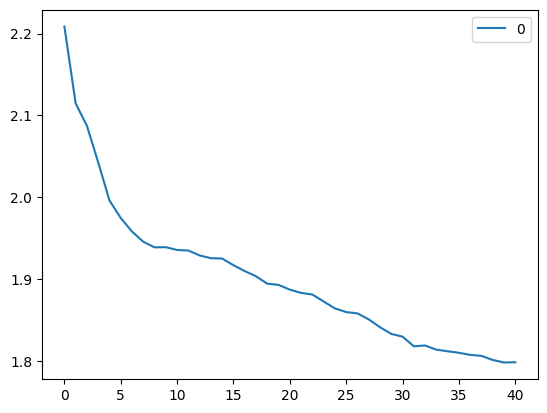

 20%|██        | 41/200 [10:08<39:02, 14.73s/it]

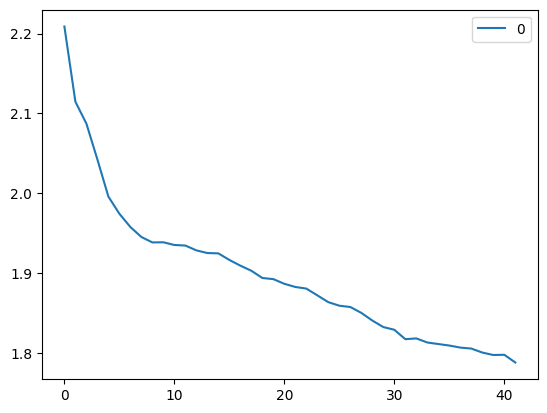

 21%|██        | 42/200 [10:22<38:32, 14.64s/it]

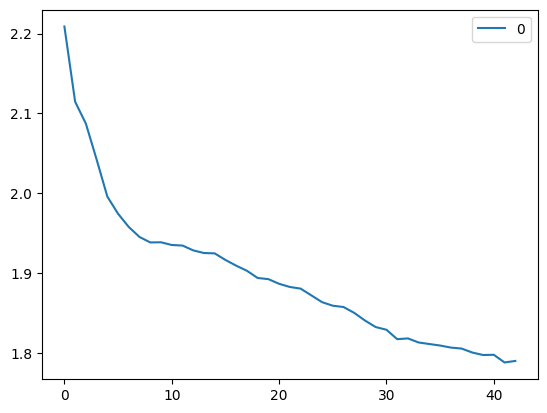

 22%|██▏       | 43/200 [10:37<38:06, 14.56s/it]

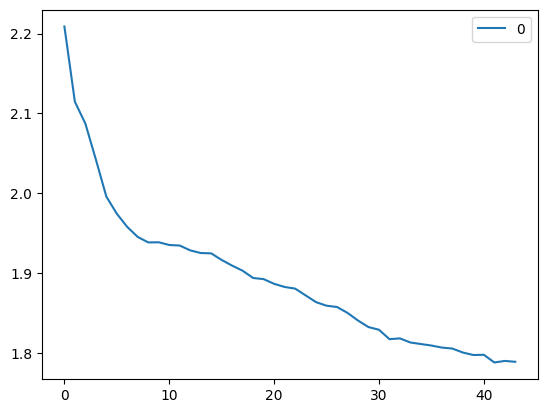

 22%|██▏       | 44/200 [10:51<37:47, 14.53s/it]

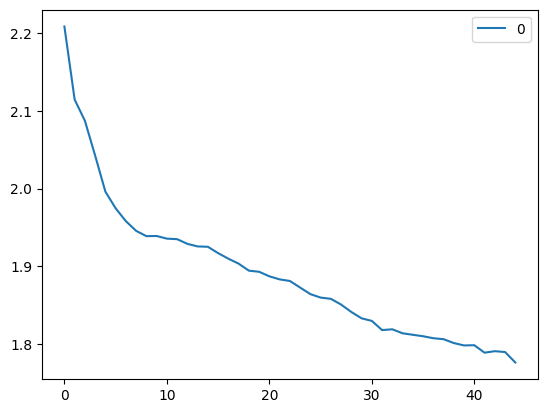

 22%|██▎       | 45/200 [11:06<37:27, 14.50s/it]

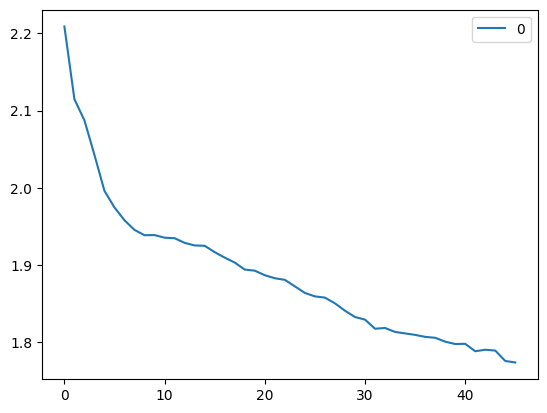

 23%|██▎       | 46/200 [11:21<37:32, 14.63s/it]

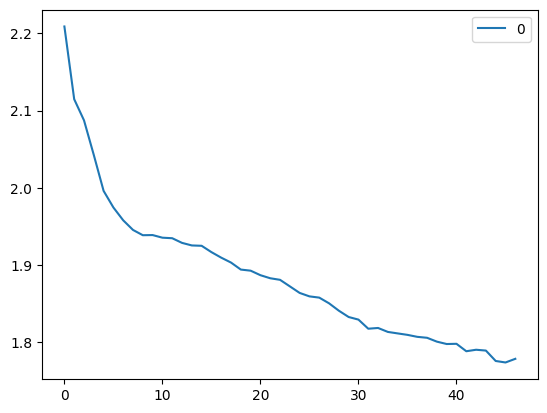

 24%|██▎       | 47/200 [11:35<37:29, 14.70s/it]

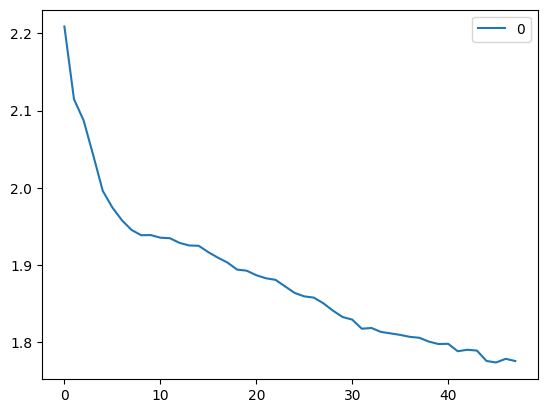

 24%|██▍       | 48/200 [11:50<36:59, 14.60s/it]

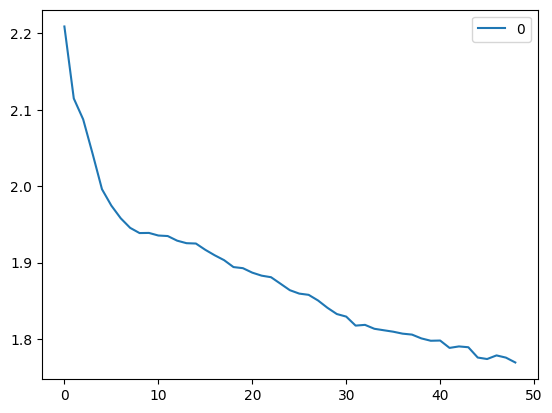

 24%|██▍       | 49/200 [12:04<36:43, 14.59s/it]

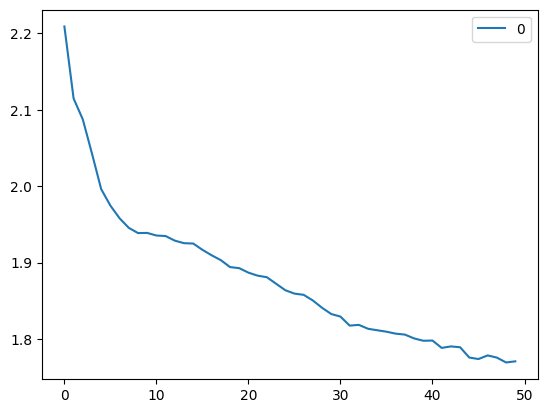

 25%|██▌       | 50/200 [12:19<36:23, 14.56s/it]

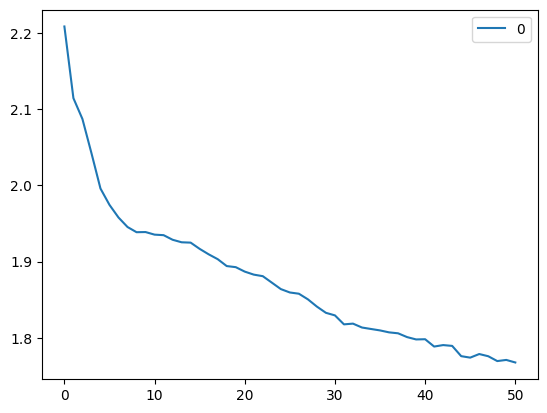

 26%|██▌       | 51/200 [12:35<37:03, 14.92s/it]

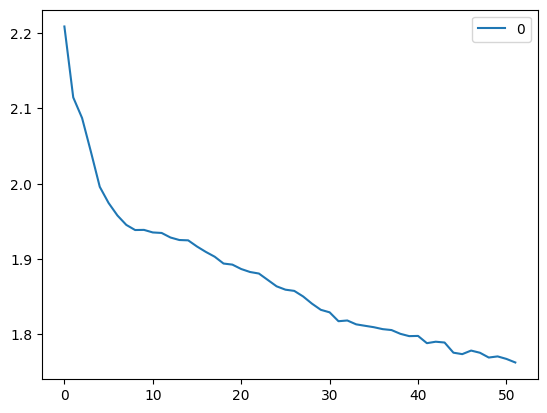

 26%|██▌       | 52/200 [12:49<36:47, 14.91s/it]

increaing the counter 0.000506882156644517


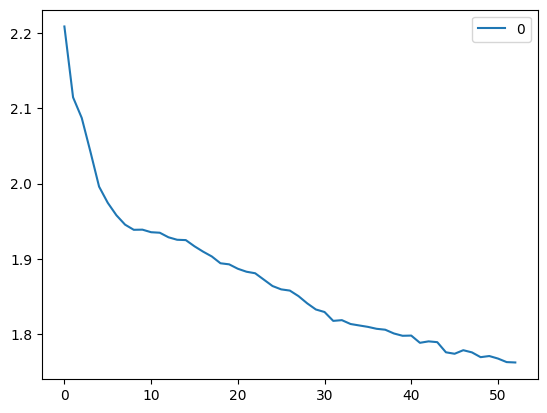

 26%|██▋       | 53/200 [13:04<36:34, 14.93s/it]

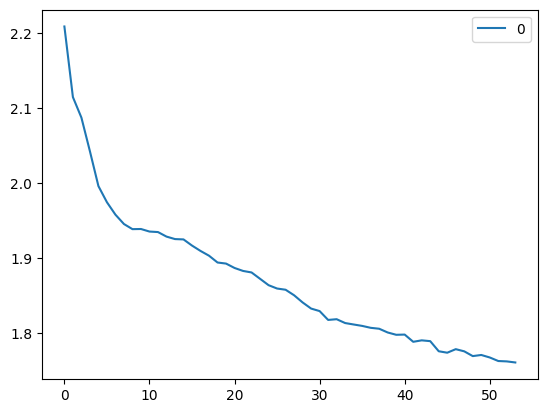

 27%|██▋       | 54/200 [13:19<36:02, 14.81s/it]

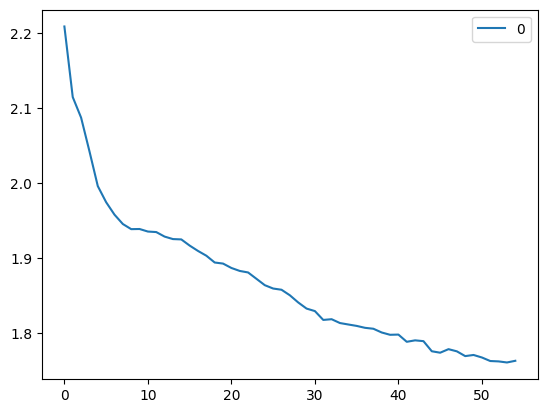

 28%|██▊       | 55/200 [13:34<35:36, 14.74s/it]

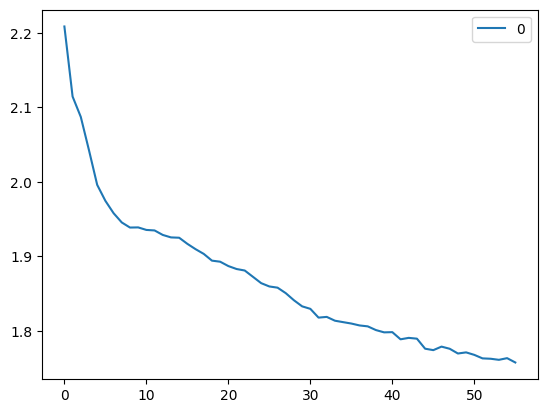

 28%|██▊       | 56/200 [13:48<35:03, 14.61s/it]

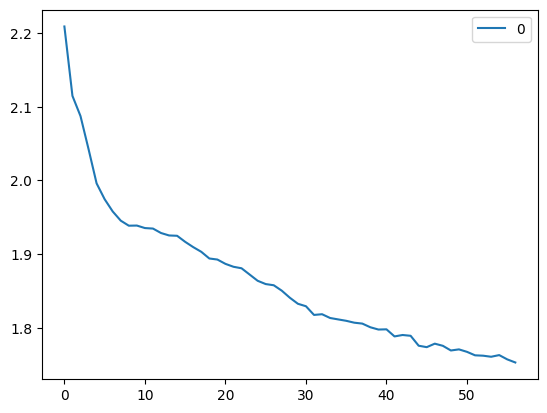

 28%|██▊       | 57/200 [14:02<34:43, 14.57s/it]

increaing the counter 0.0009285321041028194


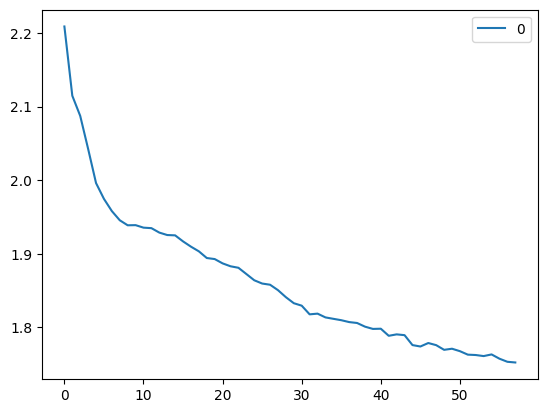

 29%|██▉       | 58/200 [14:17<34:35, 14.62s/it]

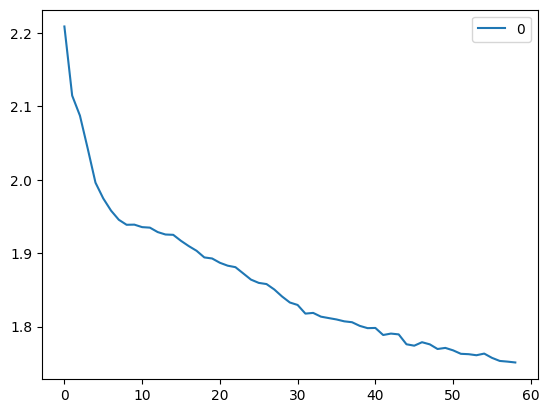

 30%|██▉       | 59/200 [14:32<34:51, 14.83s/it]

increaing the counter -0.00048013852567097004


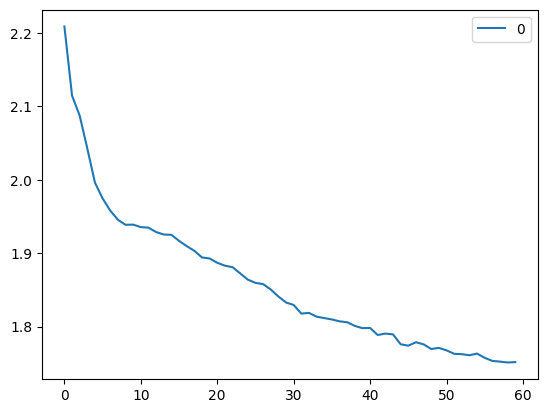

 30%|███       | 60/200 [14:47<34:24, 14.75s/it]

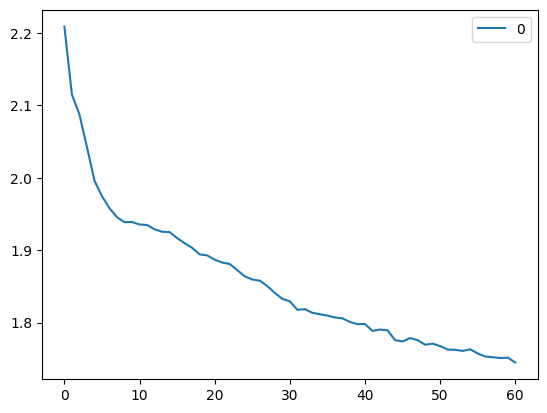

 30%|███       | 61/200 [15:02<34:08, 14.73s/it]

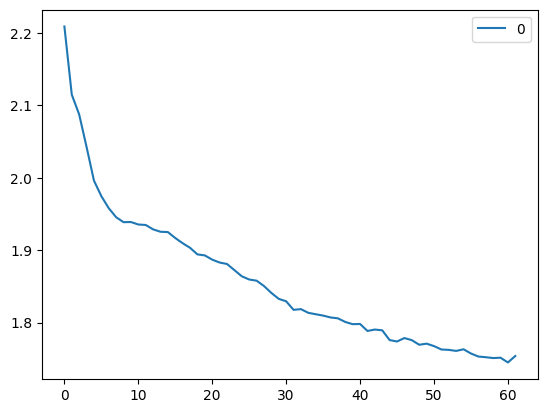

 31%|███       | 62/200 [15:17<34:00, 14.78s/it]

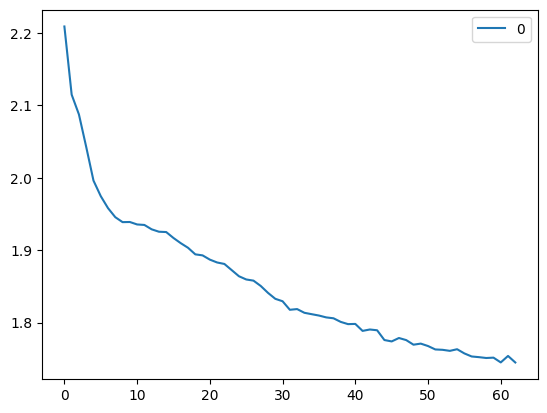

 32%|███▏      | 63/200 [15:31<33:47, 14.80s/it]

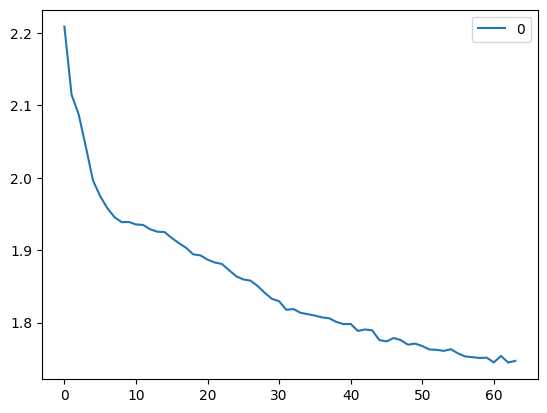

 32%|███▏      | 64/200 [15:46<33:29, 14.77s/it]

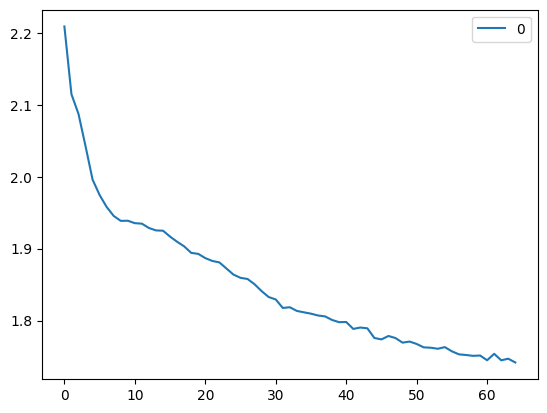

 32%|███▎      | 65/200 [16:01<33:30, 14.89s/it]

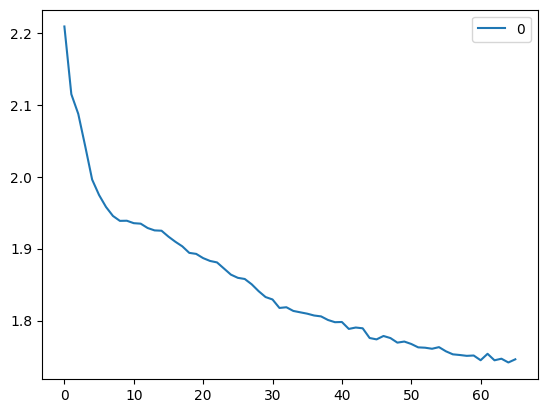

 33%|███▎      | 66/200 [16:17<33:29, 15.00s/it]

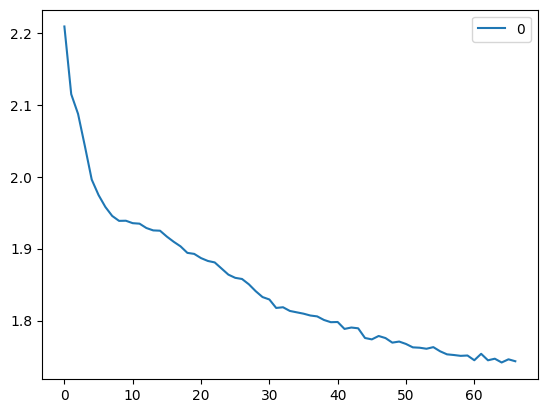

 34%|███▎      | 67/200 [16:31<33:03, 14.91s/it]

increaing the counter 7.6680767292725e-05


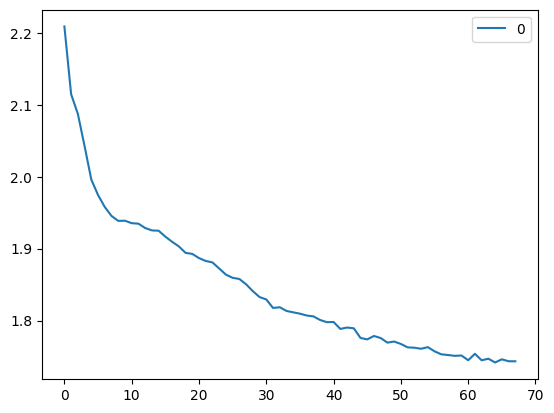

 34%|███▍      | 68/200 [16:47<33:26, 15.20s/it]

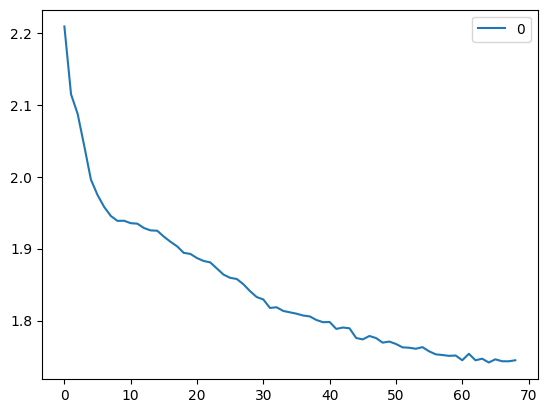

 34%|███▍      | 69/200 [17:02<32:48, 15.03s/it]

increaing the counter 0.0002964698538487909


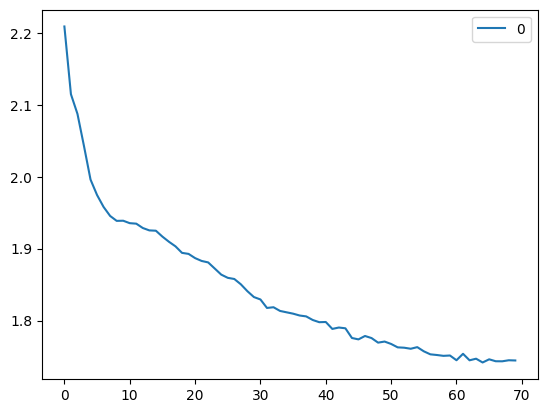

 35%|███▌      | 70/200 [17:16<32:13, 14.87s/it]

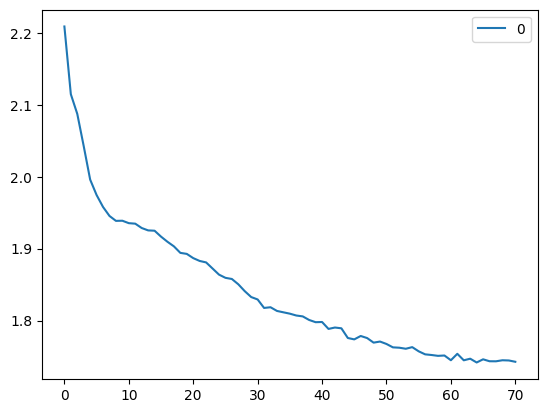

 36%|███▌      | 71/200 [17:32<32:18, 15.03s/it]

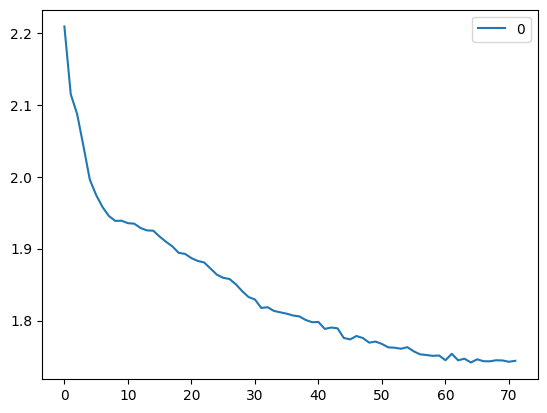

 36%|███▌      | 72/200 [17:47<32:06, 15.05s/it]

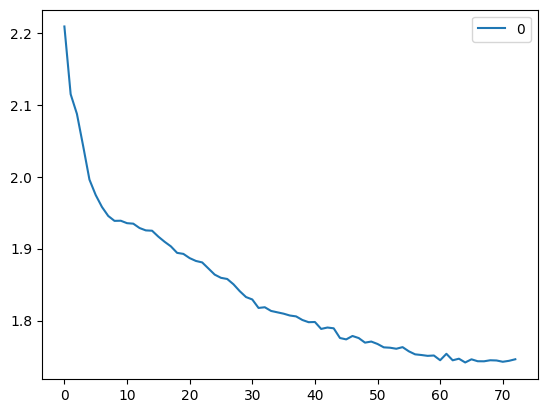

 36%|███▋      | 73/200 [18:01<31:36, 14.93s/it]

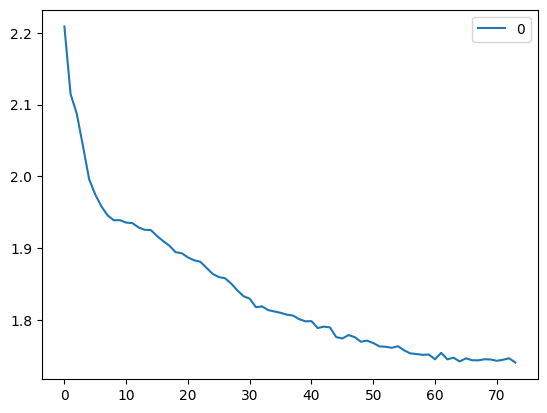

 37%|███▋      | 74/200 [18:16<31:17, 14.90s/it]

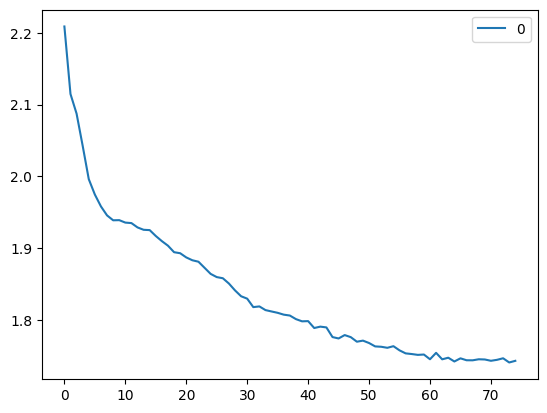

 38%|███▊      | 75/200 [18:31<30:59, 14.87s/it]

increaing the counter 0.0006333334105355082


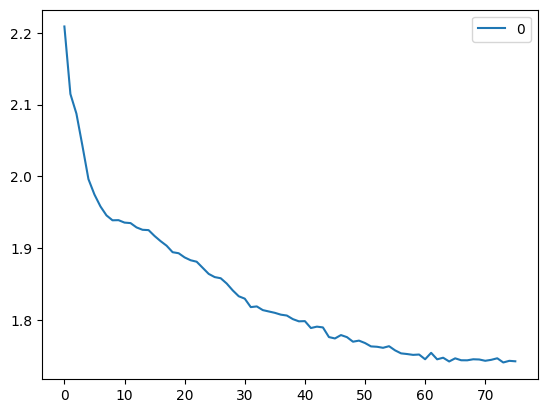

 38%|███▊      | 76/200 [18:46<30:41, 14.85s/it]

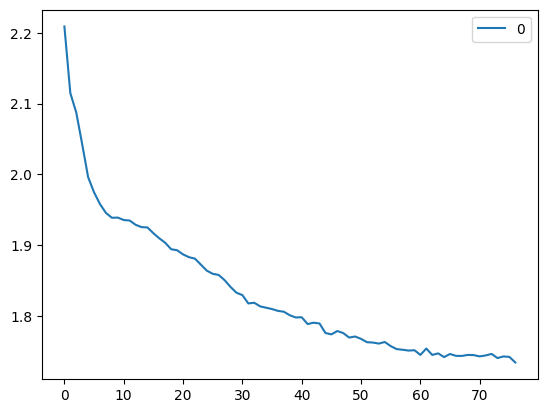

 38%|███▊      | 77/200 [19:01<30:44, 14.99s/it]

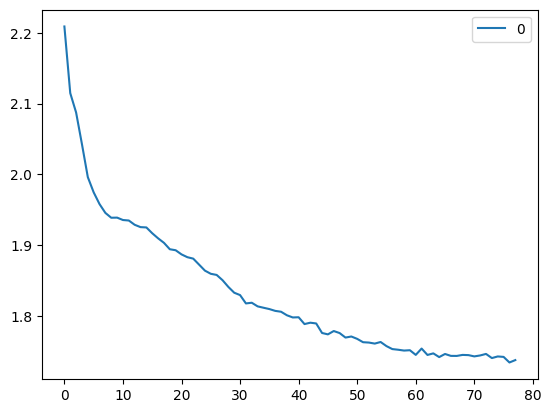

 39%|███▉      | 78/200 [19:16<30:35, 15.05s/it]

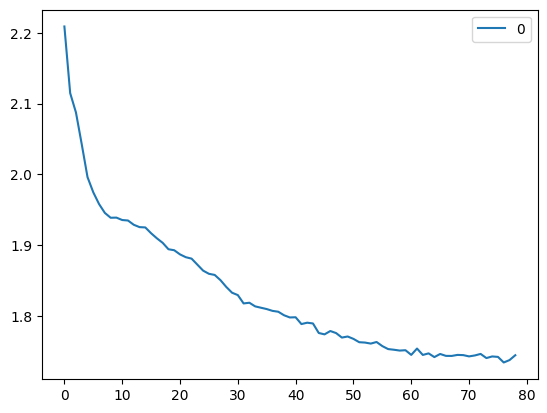

 40%|███▉      | 79/200 [19:31<29:59, 14.88s/it]

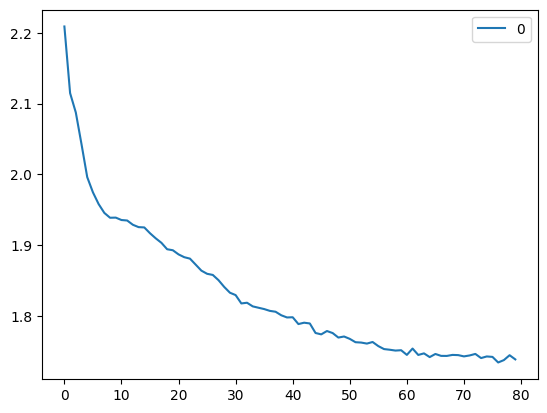

 40%|████      | 80/200 [19:46<29:42, 14.86s/it]

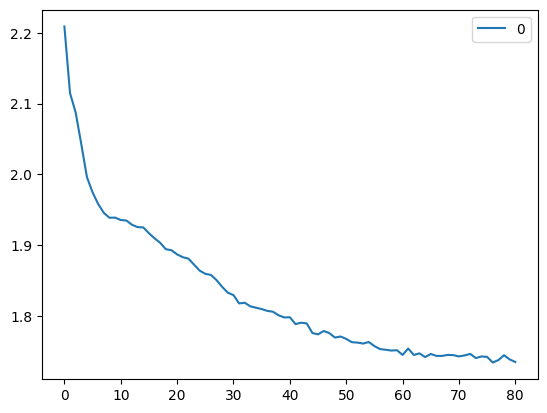

 40%|████      | 81/200 [20:00<29:16, 14.76s/it]

increaing the counter -0.00022021361759727576


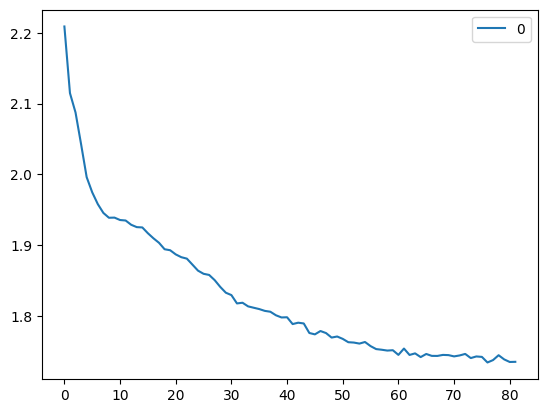

 41%|████      | 82/200 [20:15<28:55, 14.71s/it]

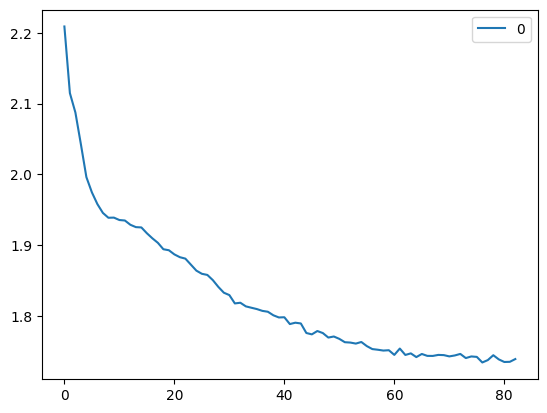

 42%|████▏     | 83/200 [20:29<28:41, 14.72s/it]

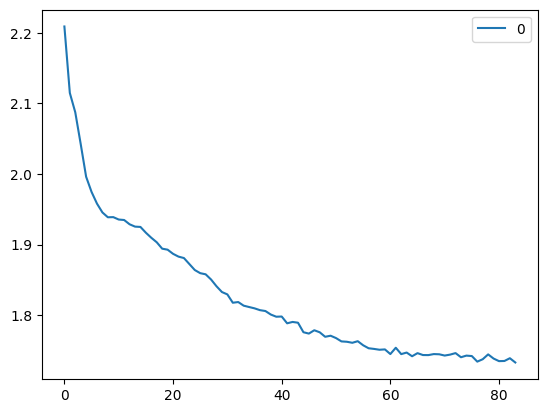

 42%|████▏     | 84/200 [20:45<28:55, 14.96s/it]

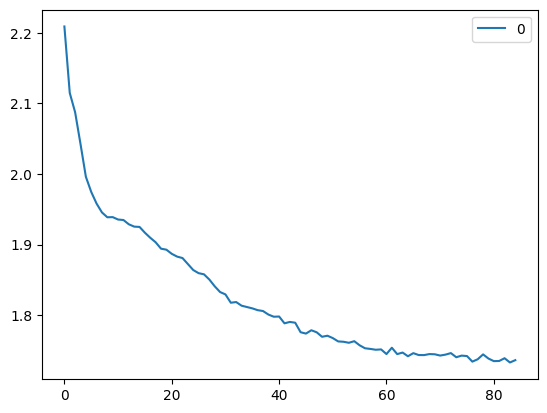

 42%|████▎     | 85/200 [21:00<28:34, 14.91s/it]

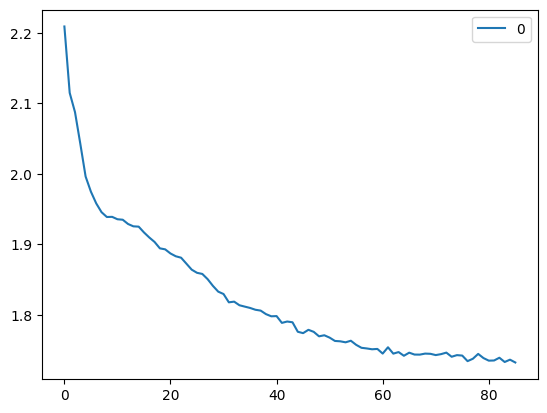

 43%|████▎     | 86/200 [21:14<28:04, 14.78s/it]

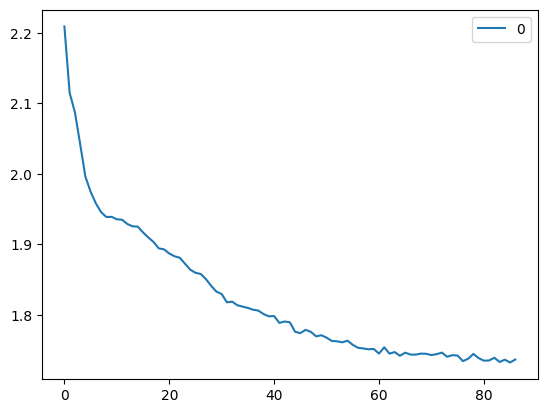

 44%|████▎     | 87/200 [21:29<27:41, 14.70s/it]

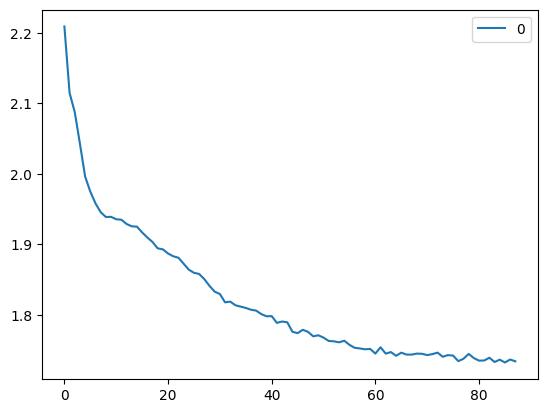

 44%|████▍     | 88/200 [21:43<27:24, 14.68s/it]

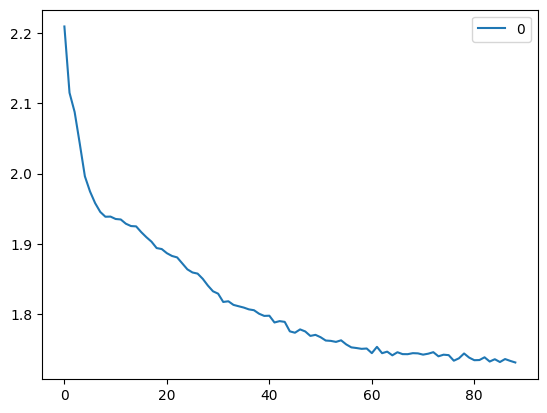

 44%|████▍     | 89/200 [21:59<27:29, 14.86s/it]

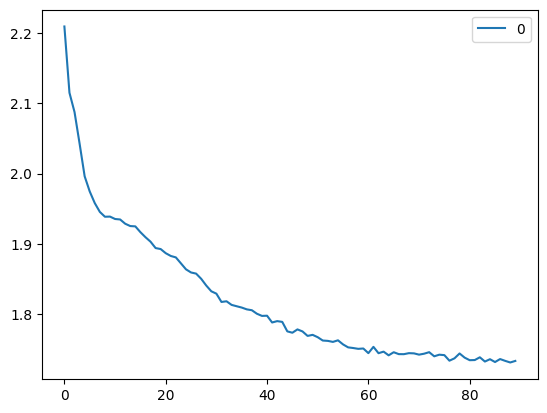

 45%|████▌     | 90/200 [22:14<27:28, 14.99s/it]

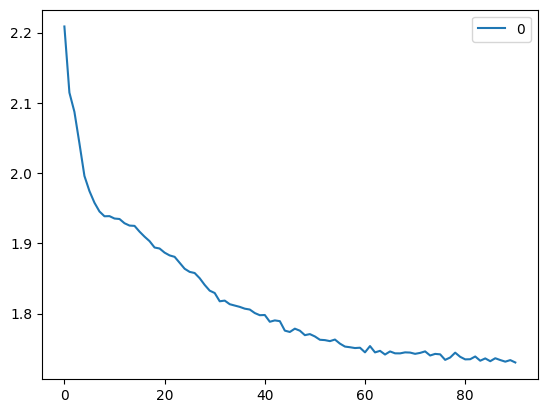

 46%|████▌     | 91/200 [22:28<26:55, 14.82s/it]

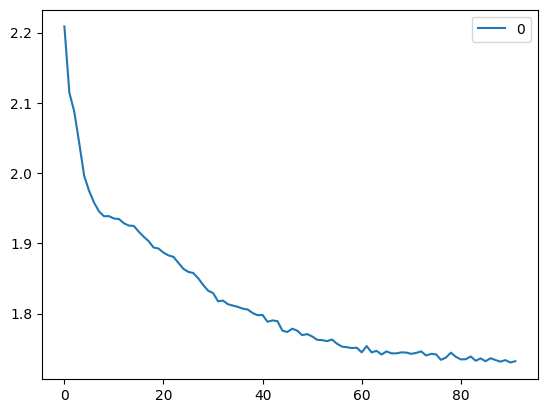

 46%|████▌     | 92/200 [22:43<26:25, 14.68s/it]

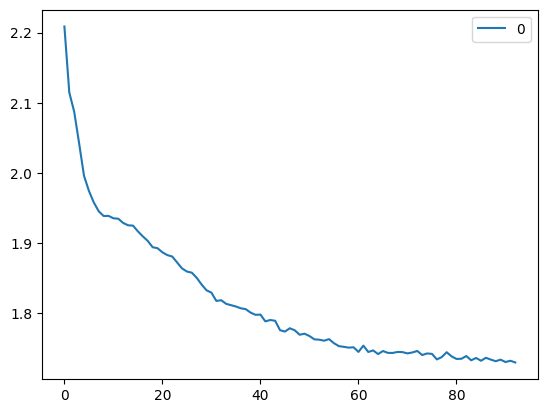

 46%|████▋     | 93/200 [22:57<26:00, 14.58s/it]

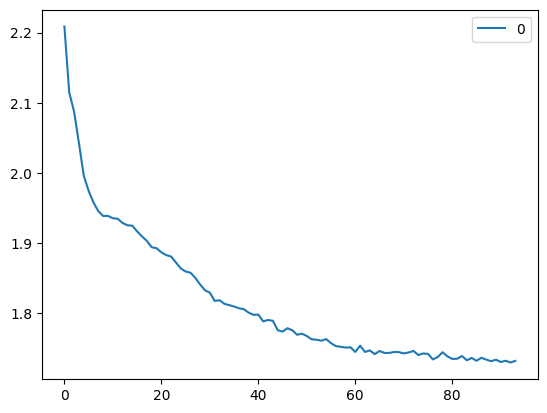

 47%|████▋     | 94/200 [23:12<25:48, 14.61s/it]

increaing the counter -0.000946901282485646


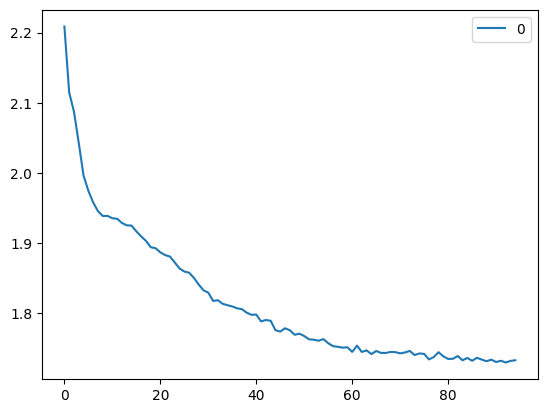

 48%|████▊     | 95/200 [23:26<25:34, 14.62s/it]

increaing the counter -0.0008831766186929713


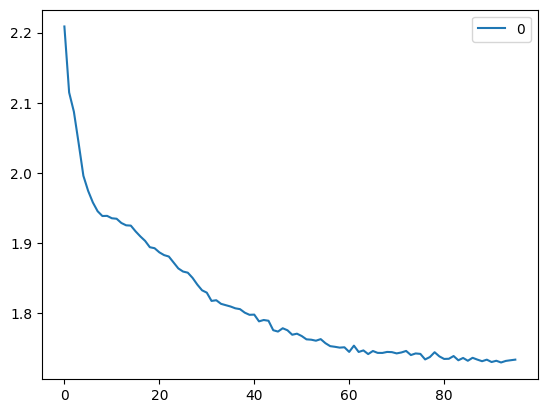

 48%|████▊     | 96/200 [23:42<25:43, 14.85s/it]

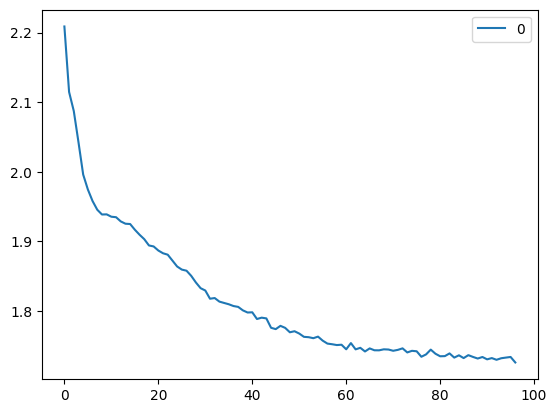

 48%|████▊     | 97/200 [23:57<25:30, 14.86s/it]

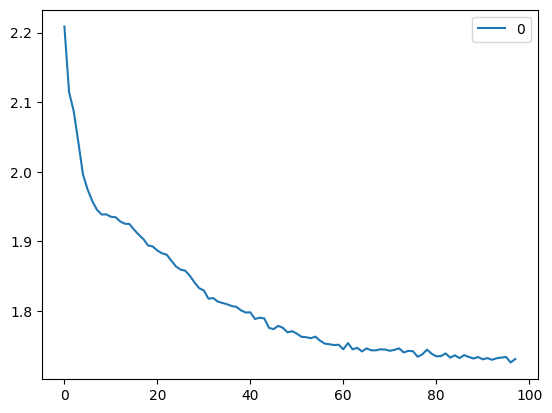

 49%|████▉     | 98/200 [24:11<25:05, 14.76s/it]

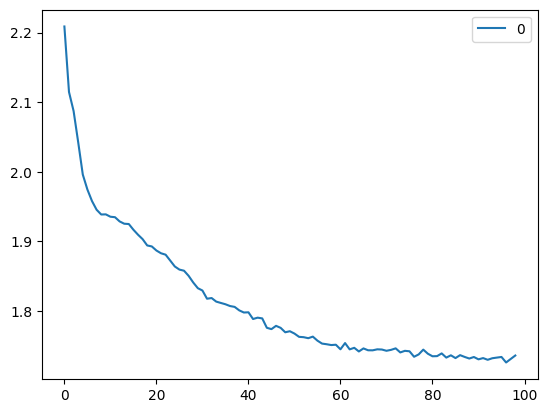

 50%|████▉     | 99/200 [24:26<24:37, 14.63s/it]

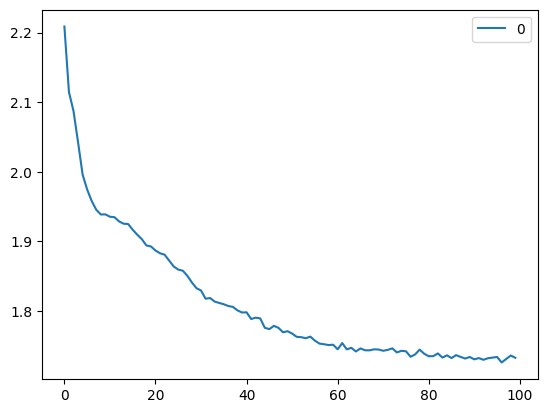

 50%|█████     | 100/200 [24:40<24:19, 14.59s/it]

increaing the counter 0.0009341696087195039


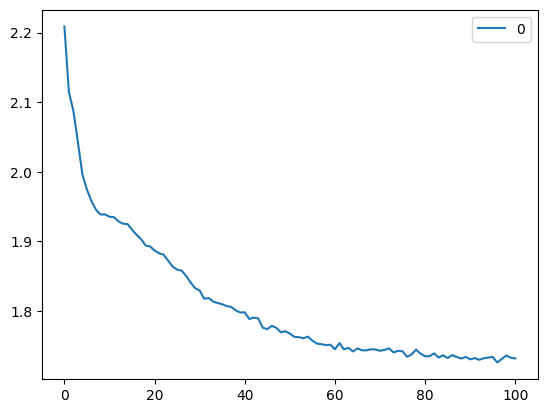

 50%|█████     | 101/200 [24:55<24:23, 14.78s/it]

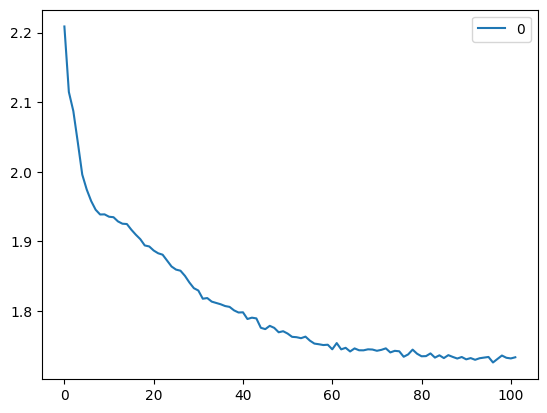

 51%|█████     | 102/200 [25:10<24:15, 14.85s/it]

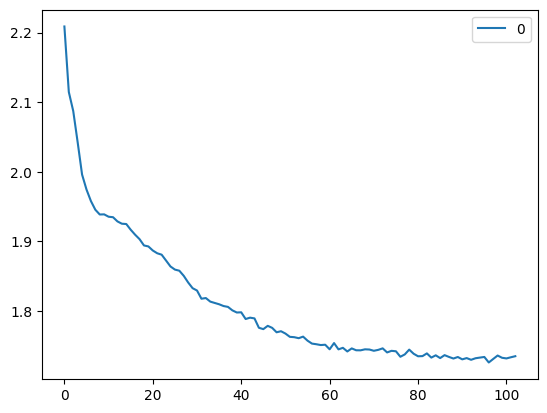

 52%|█████▏    | 103/200 [25:25<23:50, 14.75s/it]

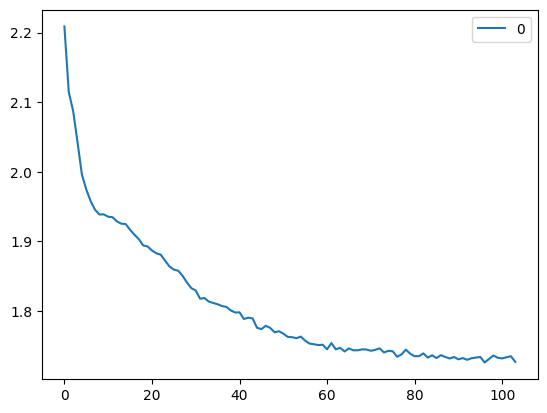

 52%|█████▏    | 104/200 [25:39<23:21, 14.60s/it]

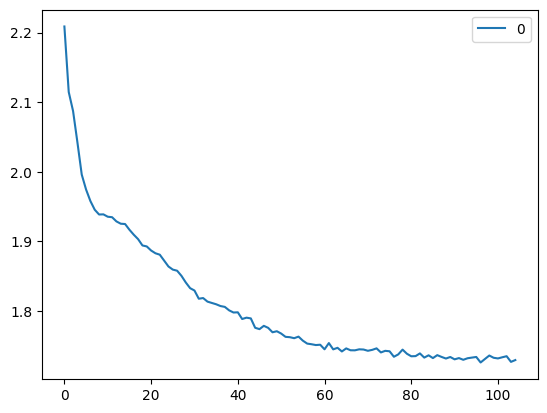

 52%|█████▎    | 105/200 [25:54<23:02, 14.56s/it]

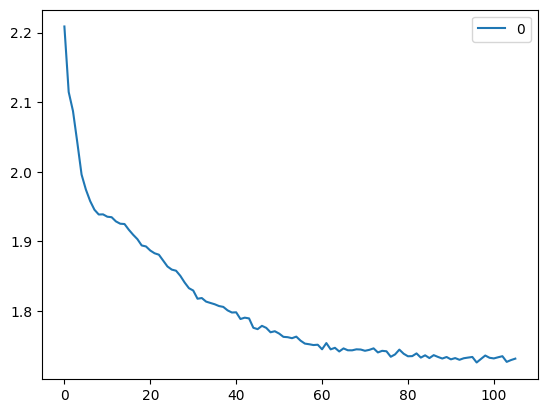

 53%|█████▎    | 106/200 [26:08<22:44, 14.51s/it]

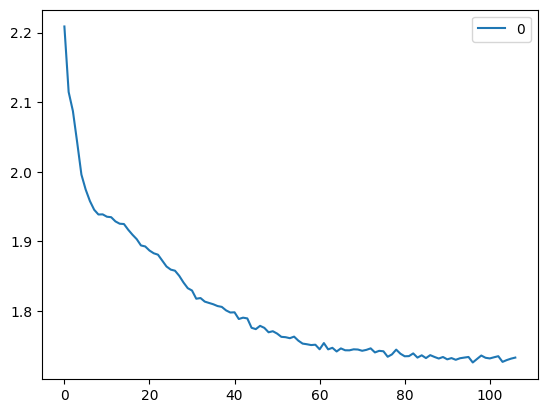

 54%|█████▎    | 107/200 [26:22<22:30, 14.53s/it]

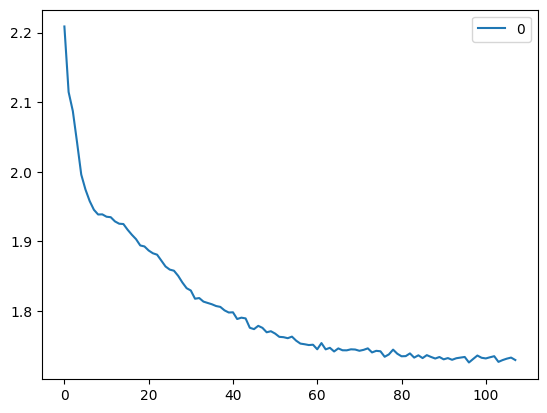

 54%|█████▍    | 108/200 [26:37<22:10, 14.46s/it]

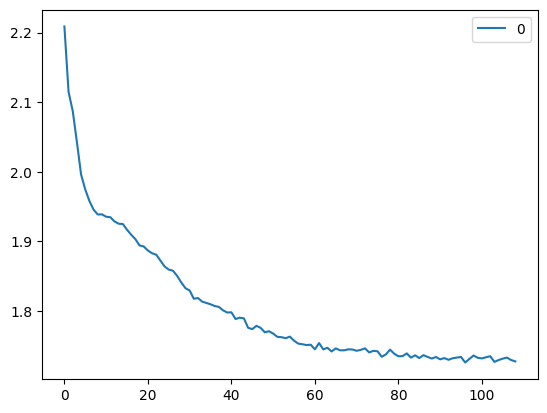

 55%|█████▍    | 109/200 [26:52<22:23, 14.77s/it]

increaing the counter -1.2665987014770508e-05


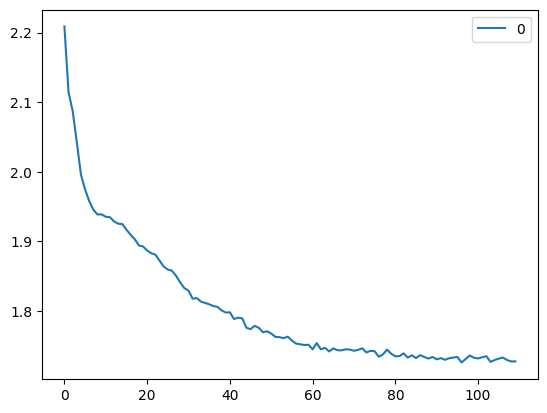

 55%|█████▌    | 110/200 [27:07<22:01, 14.68s/it]

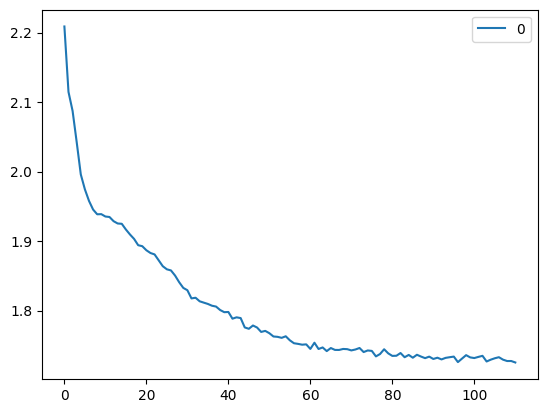

 56%|█████▌    | 111/200 [27:21<21:34, 14.55s/it]

increaing the counter -0.0002927196269133514


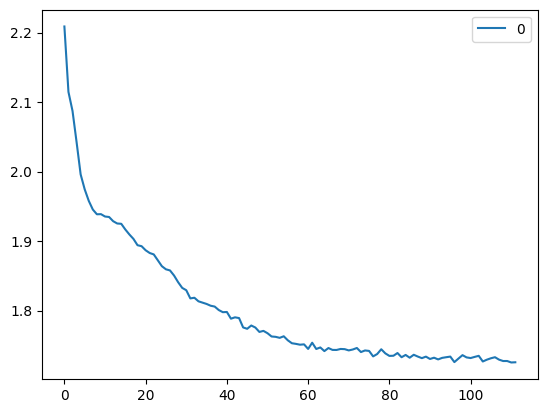

 56%|█████▌    | 112/200 [27:35<21:10, 14.44s/it]

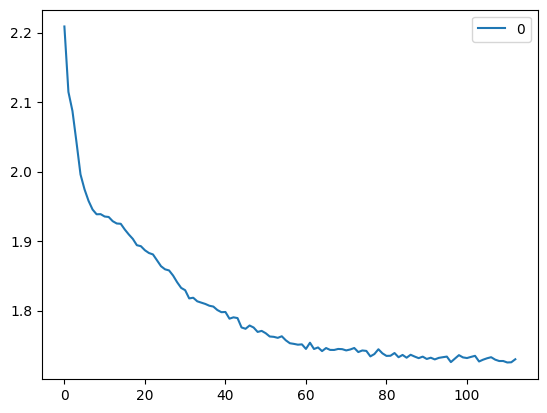

 56%|█████▋    | 113/200 [27:50<21:12, 14.62s/it]

increaing the counter -0.0006825254887952159


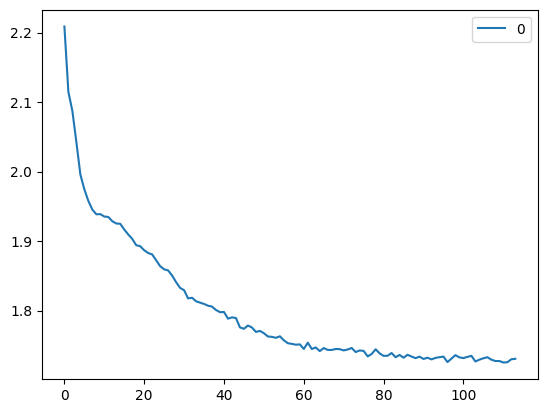

 57%|█████▋    | 114/200 [28:05<20:58, 14.64s/it]

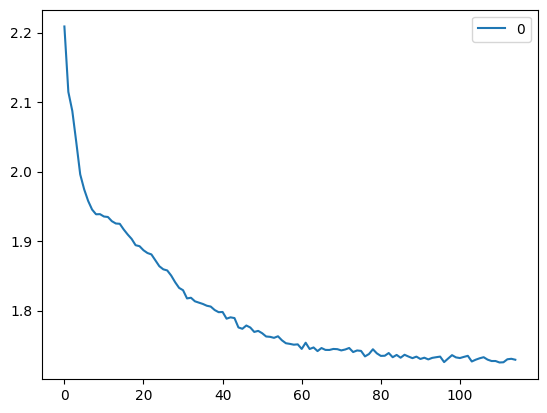

 57%|█████▊    | 115/200 [28:19<20:39, 14.59s/it]

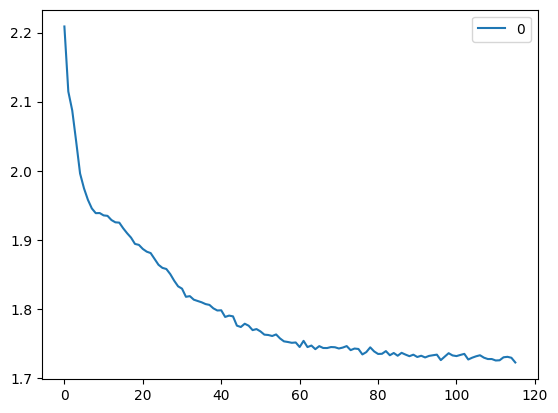

 58%|█████▊    | 116/200 [28:35<20:46, 14.84s/it]

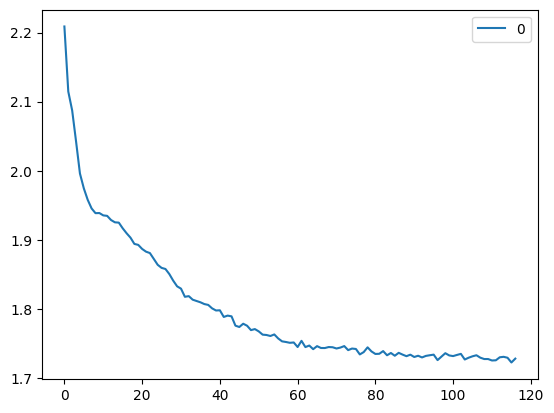

 58%|█████▊    | 117/200 [28:49<20:22, 14.73s/it]

increaing the counter -0.0007529459437545238


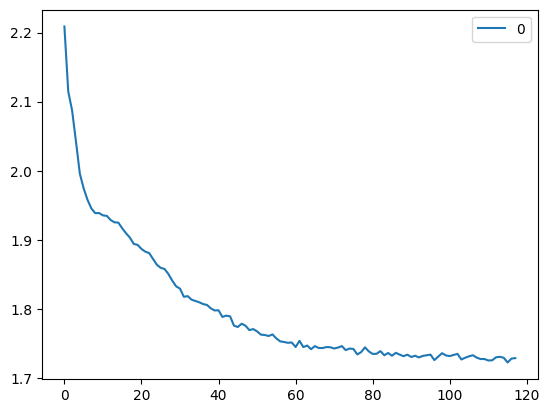

 59%|█████▉    | 118/200 [29:05<20:26, 14.95s/it]

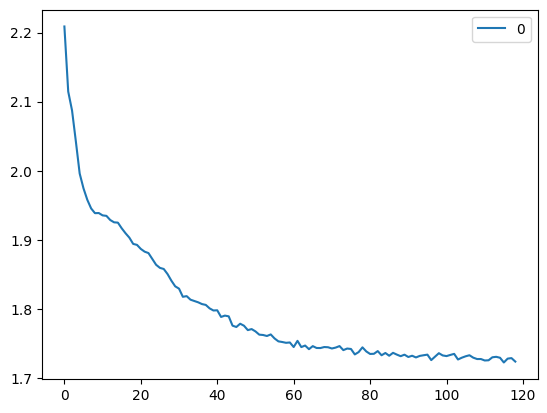

 60%|█████▉    | 119/200 [29:19<19:54, 14.75s/it]

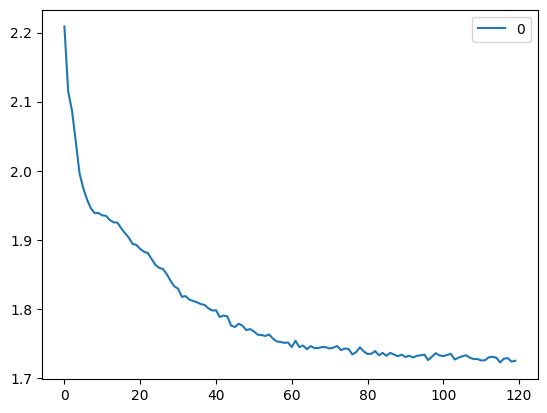

 60%|██████    | 120/200 [29:33<19:24, 14.55s/it]

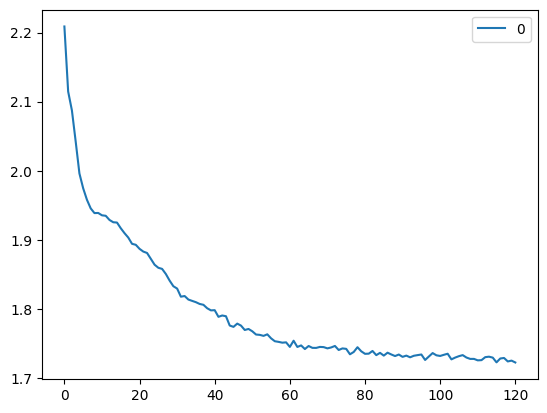

 60%|██████    | 121/200 [29:48<19:11, 14.58s/it]

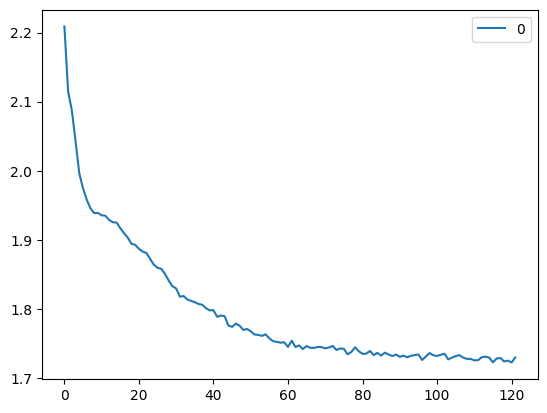

 61%|██████    | 122/200 [30:02<18:46, 14.44s/it]

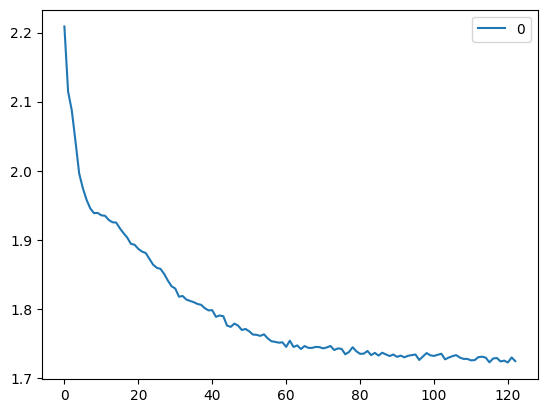

 62%|██████▏   | 123/200 [30:16<18:18, 14.27s/it]

increaing the counter -2.145949675114167e-05


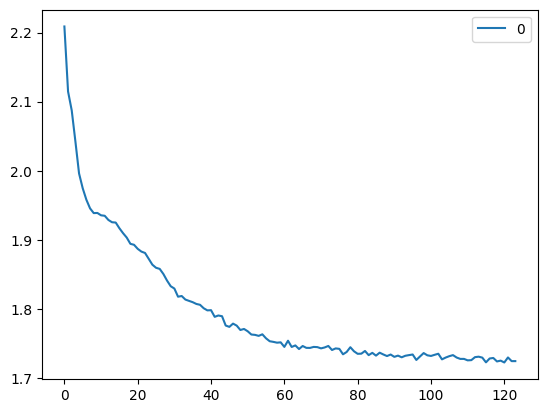

 62%|██████▏   | 124/200 [30:30<18:01, 14.23s/it]

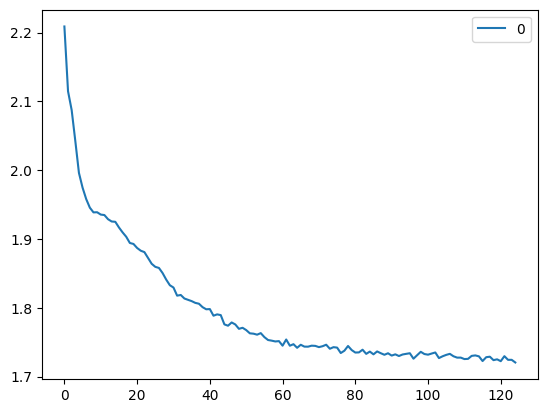

 62%|██████▎   | 125/200 [30:44<17:41, 14.15s/it]

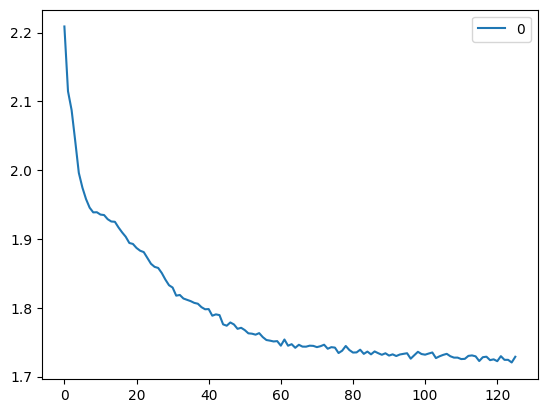

 63%|██████▎   | 126/200 [30:58<17:33, 14.23s/it]

increaing the counter 0.000714634146009141


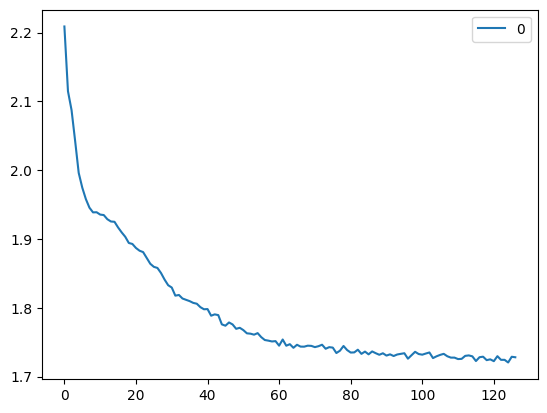

 64%|██████▎   | 127/200 [31:13<17:20, 14.25s/it]

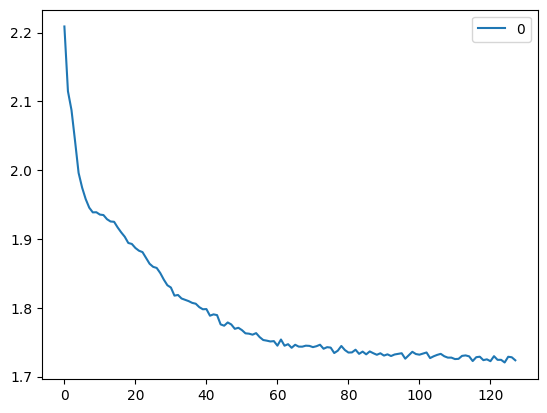

 64%|██████▍   | 128/200 [31:27<16:59, 14.16s/it]

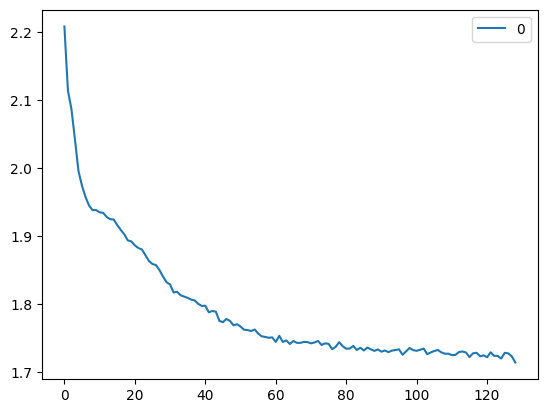

 64%|██████▍   | 129/200 [31:40<16:39, 14.08s/it]

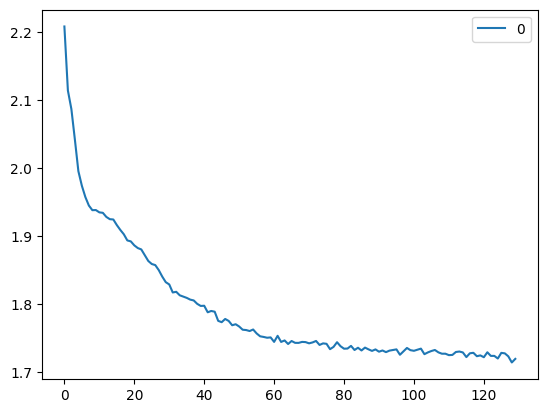

 65%|██████▌   | 130/200 [31:54<16:22, 14.03s/it]

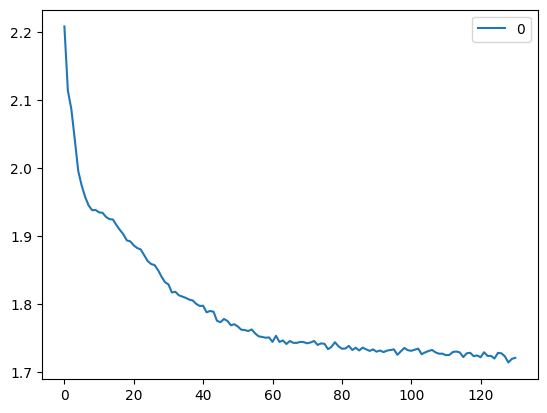

 66%|██████▌   | 131/200 [32:09<16:17, 14.16s/it]

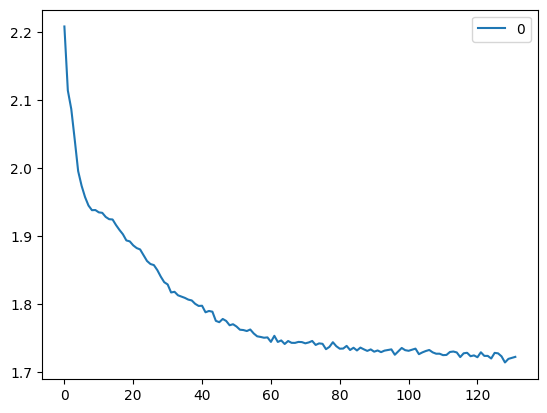

 66%|██████▌   | 132/200 [32:23<15:58, 14.09s/it]

increaing the counter -0.0005511112359106729


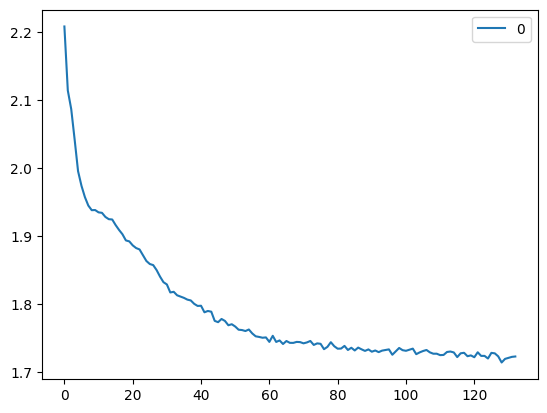

 66%|██████▋   | 133/200 [32:37<15:41, 14.05s/it]

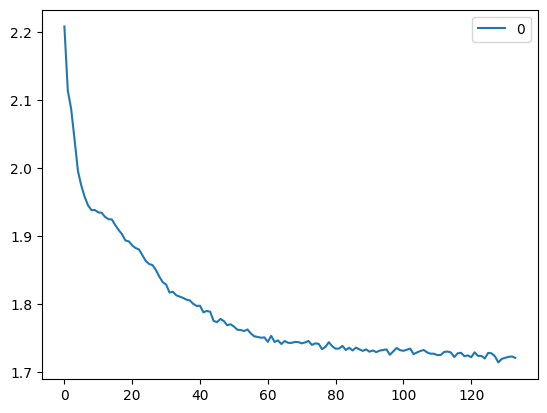

 67%|██████▋   | 134/200 [32:51<15:25, 14.02s/it]

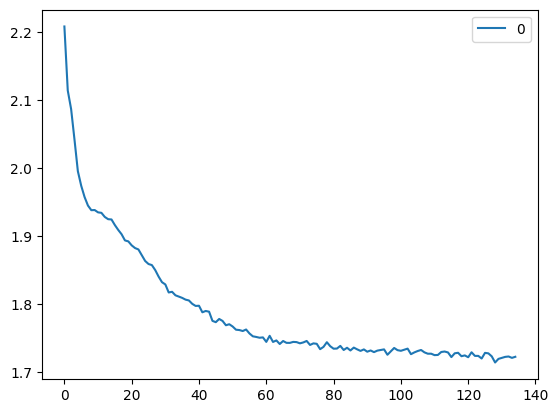

 68%|██████▊   | 135/200 [33:04<15:07, 13.96s/it]

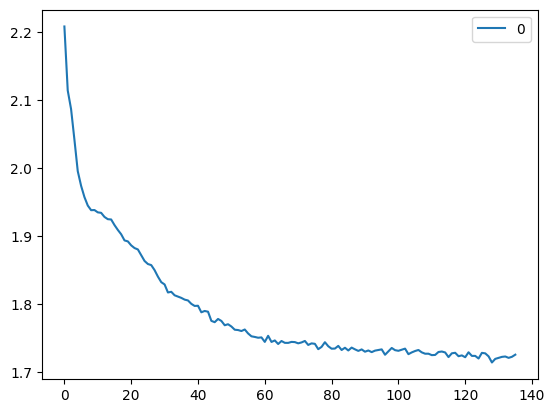

 68%|██████▊   | 136/200 [33:19<15:14, 14.29s/it]

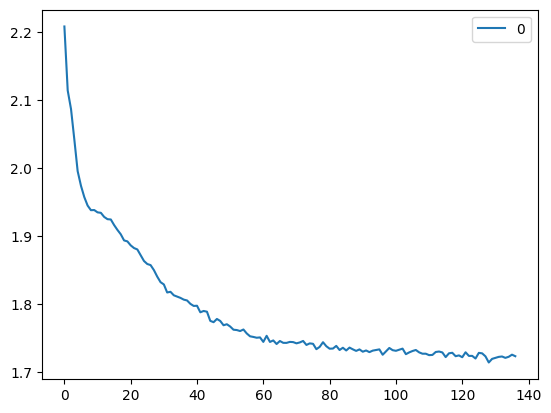

 68%|██████▊   | 137/200 [33:34<14:57, 14.25s/it]

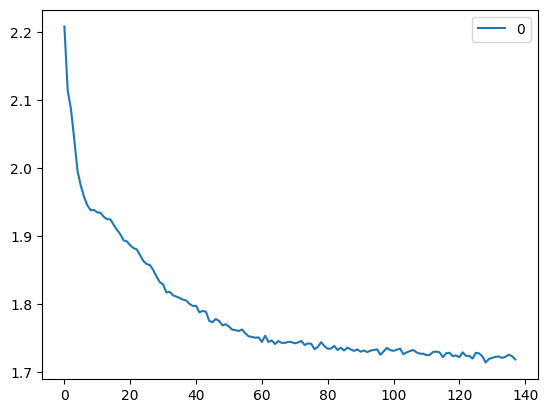

 69%|██████▉   | 138/200 [33:48<14:41, 14.22s/it]

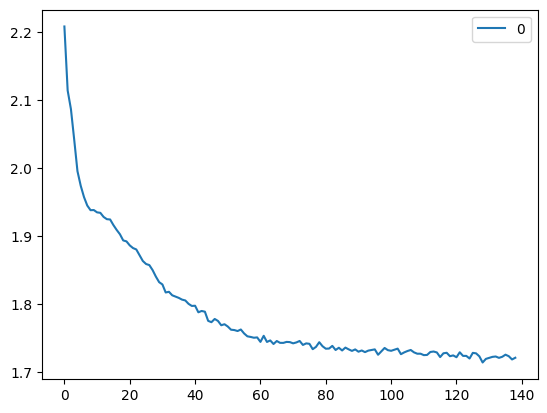

 70%|██████▉   | 139/200 [34:02<14:30, 14.27s/it]

increaing the counter 0.0001810083583910771


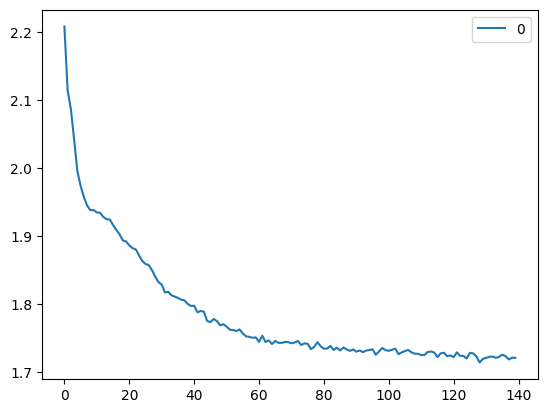

 70%|███████   | 140/200 [34:17<14:18, 14.30s/it]

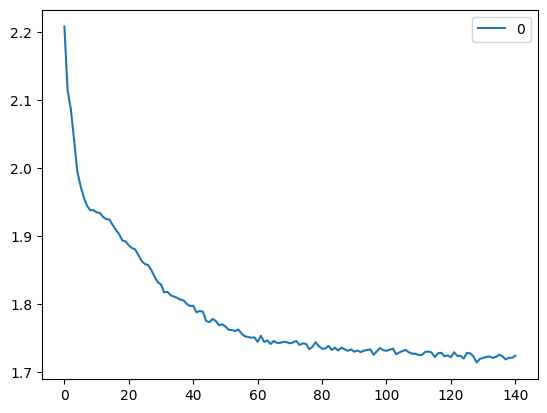

 70%|███████   | 141/200 [34:31<14:05, 14.33s/it]

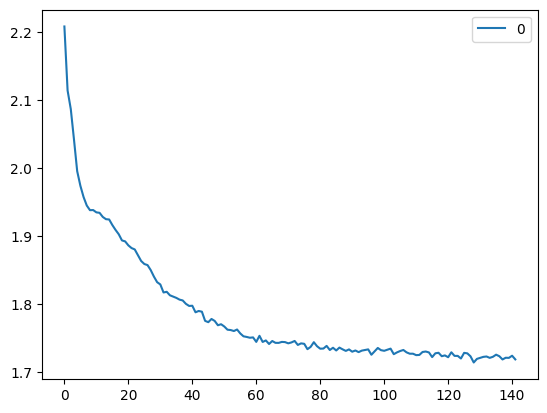

 71%|███████   | 142/200 [34:45<13:53, 14.37s/it]

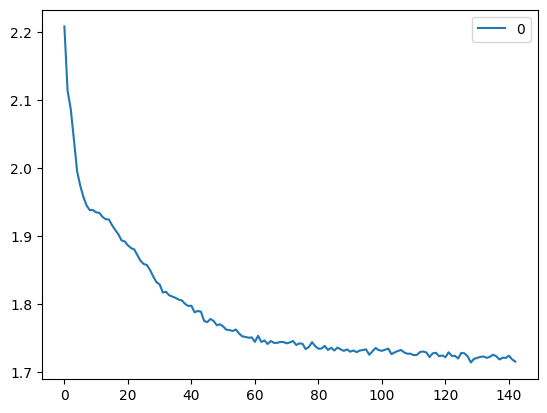

 72%|███████▏  | 143/200 [34:59<13:33, 14.28s/it]

increaing the counter 0.0005220910724328398


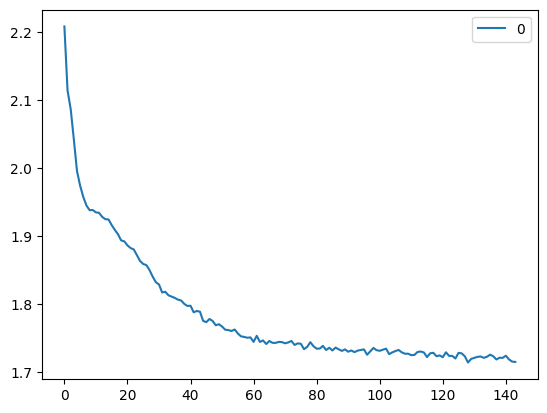

 72%|███████▏  | 144/200 [35:14<13:20, 14.29s/it]

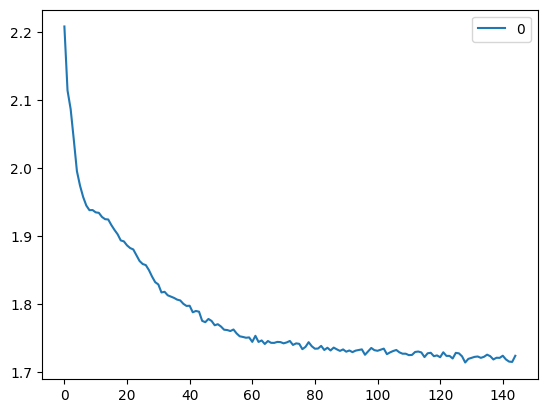

 72%|███████▎  | 145/200 [35:28<13:00, 14.19s/it]

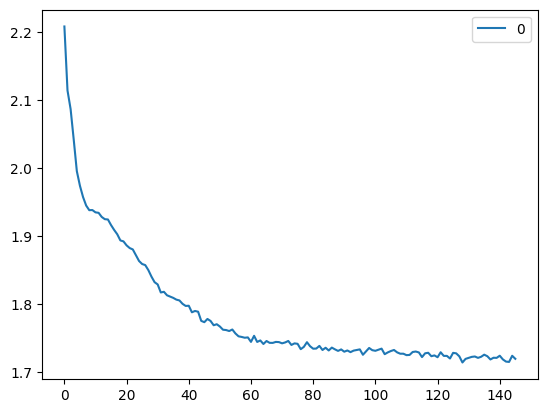

 73%|███████▎  | 146/200 [35:42<12:52, 14.30s/it]

increaing the counter -0.00041160352376024


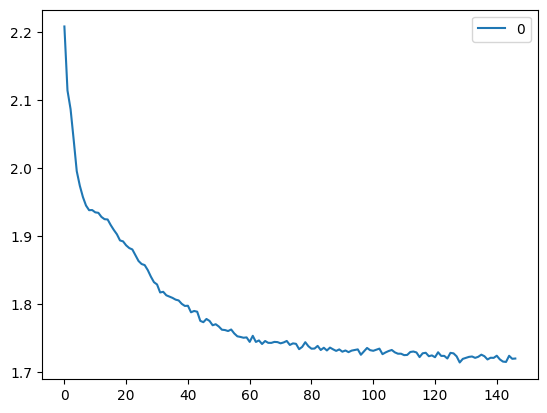

 74%|███████▎  | 147/200 [35:56<12:33, 14.23s/it]

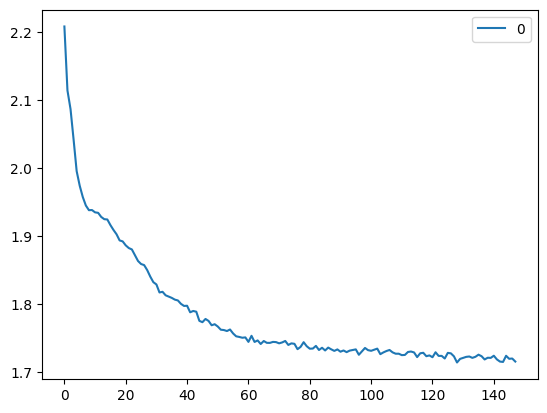

 74%|███████▍  | 148/200 [36:10<12:14, 14.13s/it]

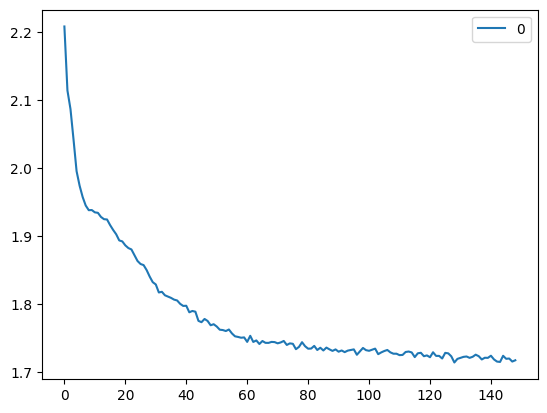

 74%|███████▍  | 149/200 [36:24<11:54, 14.02s/it]

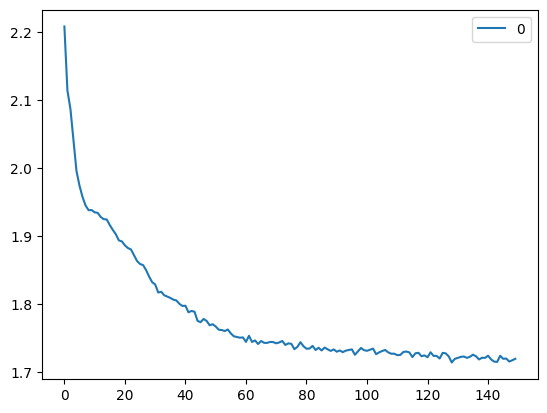

 75%|███████▌  | 150/200 [36:38<11:42, 14.05s/it]

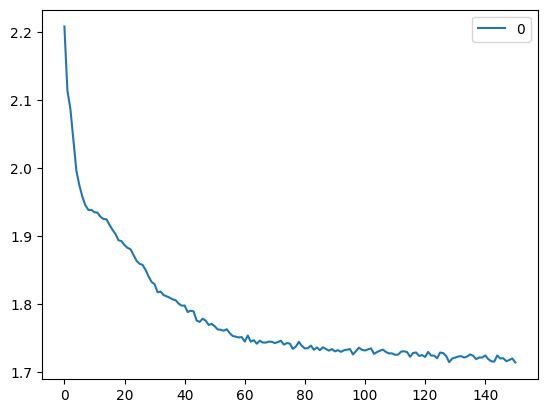

 76%|███████▌  | 151/200 [36:52<11:30, 14.08s/it]

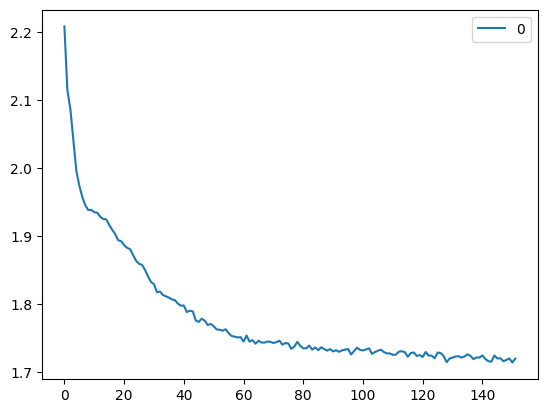

 76%|███████▌  | 152/200 [37:06<11:16, 14.10s/it]

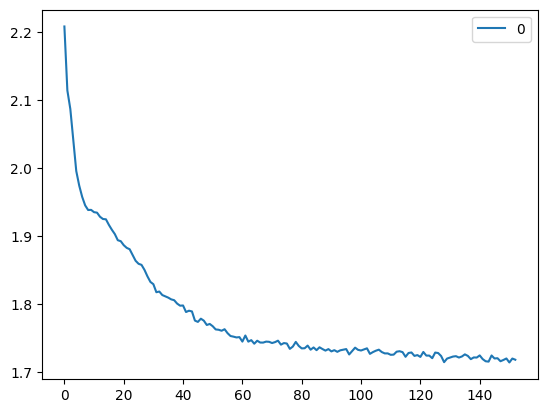

 76%|███████▋  | 153/200 [37:21<11:13, 14.32s/it]

increaing the counter -0.00020852867437870515


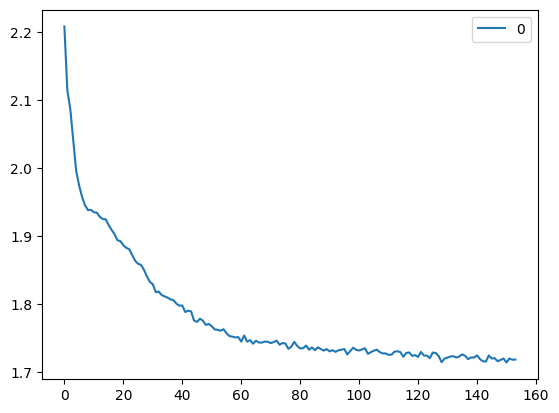

 77%|███████▋  | 154/200 [37:35<10:53, 14.21s/it]

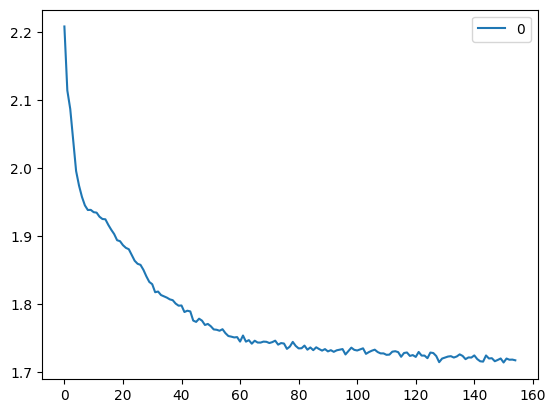

 78%|███████▊  | 155/200 [37:49<10:37, 14.18s/it]

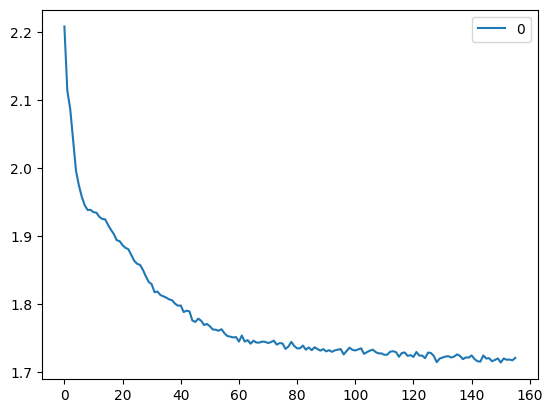

 78%|███████▊  | 156/200 [38:04<10:28, 14.29s/it]

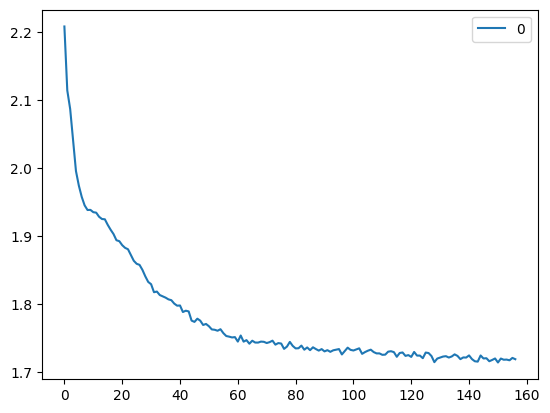

 78%|███████▊  | 157/200 [38:18<10:17, 14.37s/it]

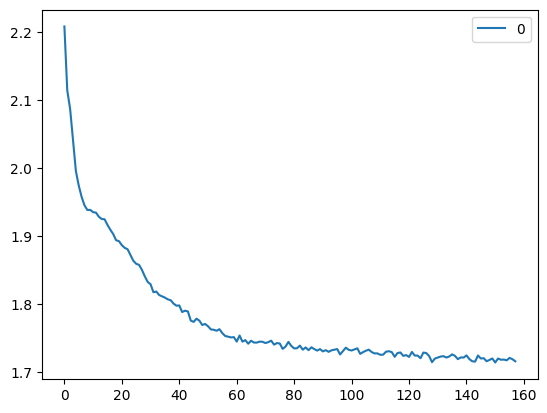

 79%|███████▉  | 158/200 [38:33<10:00, 14.31s/it]

increaing the counter 0.0005934797987645624


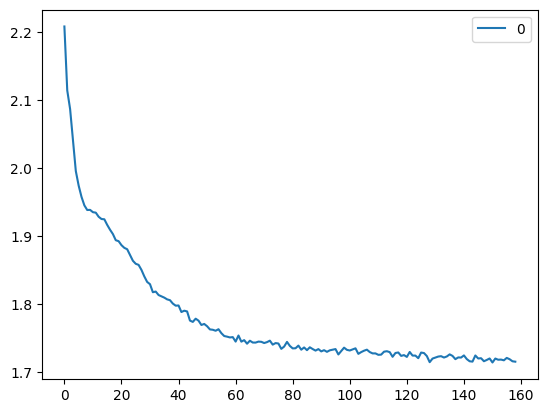

 80%|███████▉  | 159/200 [38:46<09:39, 14.14s/it]

increaing the counter -0.0009912331493533433


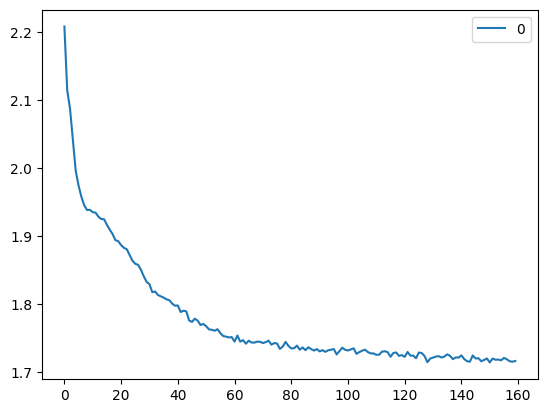

 80%|████████  | 160/200 [39:00<09:20, 14.02s/it]

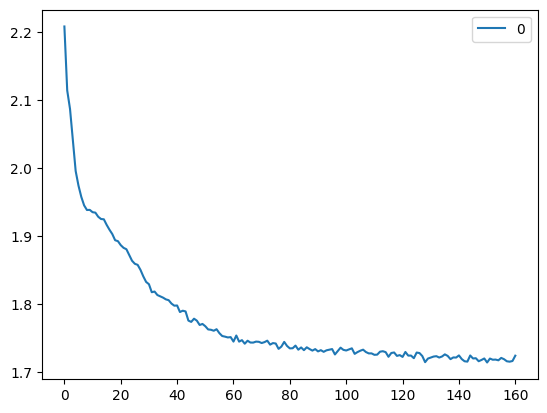

 80%|████████  | 161/200 [39:14<09:08, 14.05s/it]

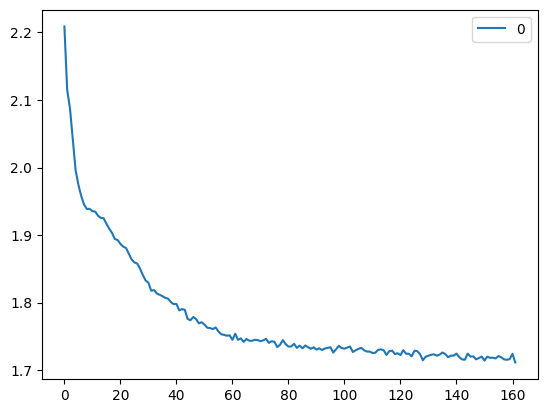

 81%|████████  | 162/200 [39:30<09:10, 14.49s/it]

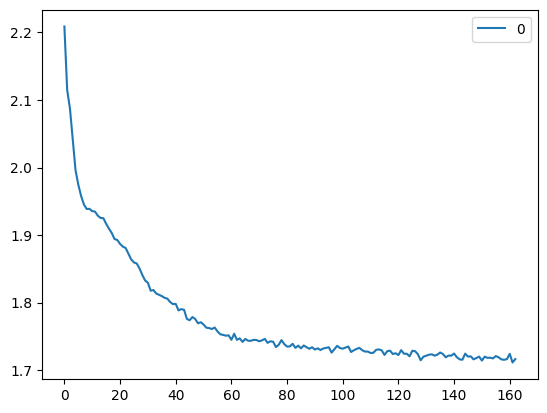

 82%|████████▏ | 163/200 [39:44<08:51, 14.37s/it]

increaing the counter -0.0006522116612415196


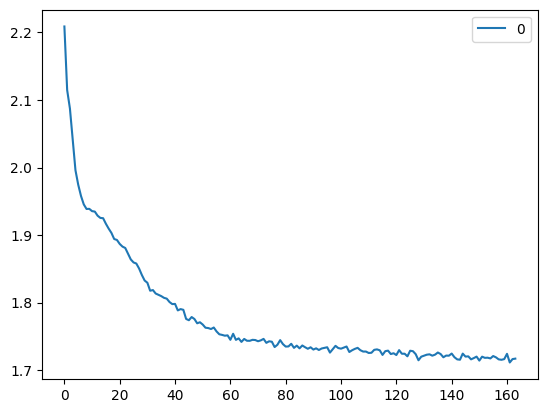

 82%|████████▏ | 164/200 [39:58<08:36, 14.35s/it]

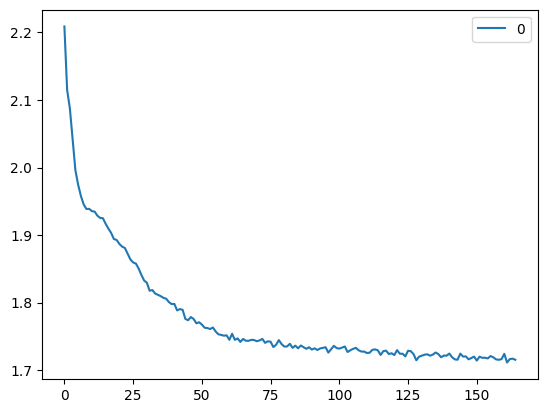

 82%|████████▎ | 165/200 [40:13<08:24, 14.43s/it]

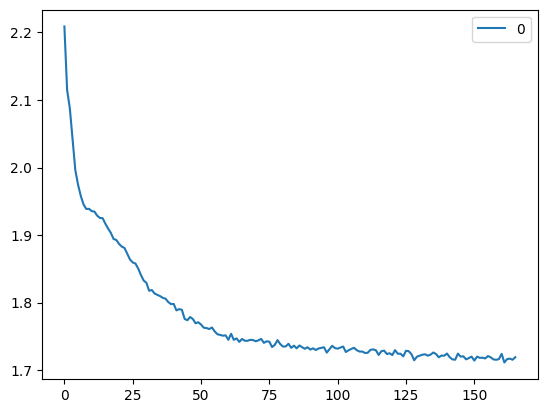

 83%|████████▎ | 166/200 [40:28<08:15, 14.56s/it]

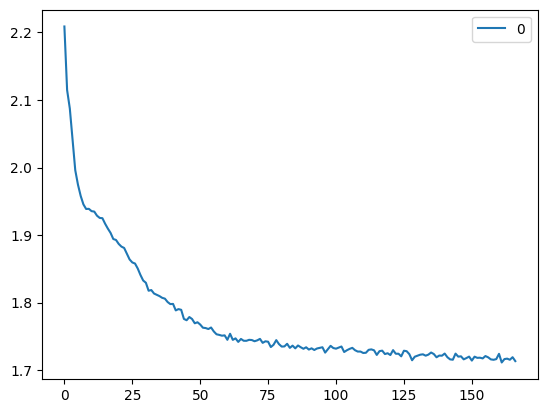

 84%|████████▎ | 167/200 [40:42<08:01, 14.58s/it]

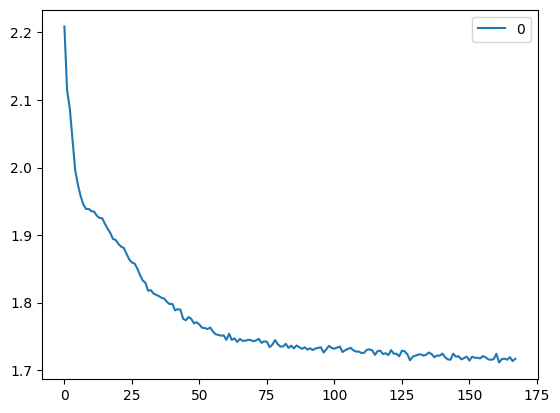

 84%|████████▍ | 168/200 [40:57<07:48, 14.63s/it]

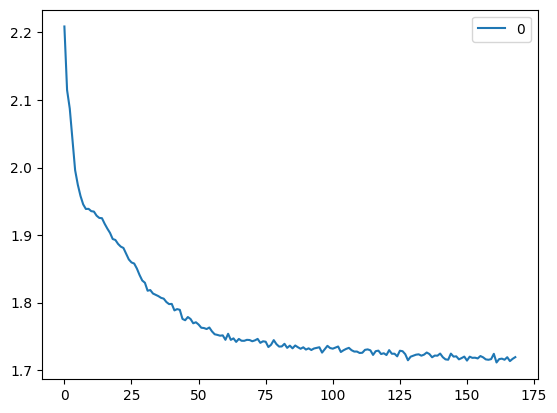

 84%|████████▍ | 169/200 [41:12<07:33, 14.63s/it]

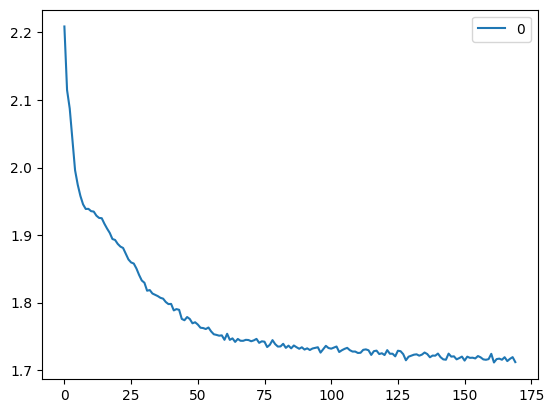

 85%|████████▌ | 170/200 [41:28<07:30, 15.03s/it]

In [ ]:
noisy_model,epoch_log=train_VGG(model,synthetic_dataset,config,'cuda')

In [ ]:
noisy_model

NameError: ignored

#### Forget and Retain

In [ ]:
# Class split
retain_dataloader = torch.utils.data.DataLoader(class_datasets['retain'], batch_size=128, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(class_datasets['forget'], batch_size=128, shuffle=True, num_workers=2)

# Random split
# train_split_dataset,forget_split_dataset=torch.utils.data.random_split(train_dataset,lengths=[45000,5000])
# retain_dataloader = torch.utils.data.DataLoader(train_split_dataset,  batch_size=128, shuffle=True, num_workers=2)
# forget_dataloader = torch.utils.data.DataLoader(forget_split_dataset, batch_size=128, shuffle=True, num_workers=2)

# Unlearner class


### Using the Lower precision based model.
> ### There is some problems with this method. Because the counterpart gives better result.

In [ ]:
from tools.Unlearner_FM_precision import Unlearner_FM_precision
r_perf=[]

R=list(np.linspace(0.001,0.1,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM_precision(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model, mask_index,num_of_param=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader)

    forget_perf=Unlearner_FM_precision.test(new_model,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM_precision.test(new_model,retain_dataloader,'cuda')
    test_perf=Unlearner_FM_precision.test(new_model,testloader,'cuda')

    r_perf.append([forget_perf,retain_perf,test_perf])




Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:18643


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:35732


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:52822


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:69912


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:87001


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:104091


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:121180


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:138270


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:15536


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:46608


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:62144


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:77680


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:93216


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:108752


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:124288


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:139824


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:310720


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:621440


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:932160


In [ ]:
r_perf

[[0.99, 0.9992444444444445, 0.9174],
 [0.9934, 0.9991111111111111, 0.9178],
 [0.9882, 0.9975777777777778, 0.9115],
 [0.9708, 0.9993111111111111, 0.9138],
 [0.9952, 0.9982888888888889, 0.9144],
 [0.9922, 0.9974222222222222, 0.9111],
 [0.991, 0.9951111111111111, 0.9068],
 [0.9924, 0.9943555555555555, 0.905],
 [0.9806, 0.9931333333333333, 0.9031],
 [0.9854, 0.9922222222222222, 0.9031],
 [0.9954, 0.9993333333333333, 0.9183],
 [0.9812, 0.9956888888888888, 0.9092],
 [0.9872, 0.9987777777777778, 0.9155],
 [0.9956, 0.9985111111111111, 0.9162],
 [0.9908, 0.9981333333333333, 0.9132],
 [0.9782, 0.9747333333333333, 0.8839],
 [0.991, 0.9957777777777778, 0.9076],
 [0.9952, 0.9934888888888889, 0.9071],
 [0.9852, 0.9915333333333334, 0.9011],
 [0.9944, 0.9938444444444444, 0.9056],
 [0.1416, 0.8173333333333334, 0.6768],
 [0.0, 0.1111111111111111, 0.1],
 [0.0, 0.1111111111111111, 0.1]]

In [ ]:
r_perf

[[0.1822, 0.565, 0.4987],
 [0.9948, 0.9994666666666666, 0.9186],
 [0.9908, 0.9979333333333333, 0.9122],
 [0.9624, 0.9833111111111111, 0.892],
 [0.9408, 0.9732222222222222, 0.8727],
 [0.6086, 0.8173333333333334, 0.7206]]

### Counterpart: Maintaining the original precision of the model and diverting some operation to CPU.

In [ ]:
# from tools.Unlearner_FM import Unlearner_FM
# torch.cuda.empty_cache()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
# unlearner_1 = Unlearner_FM(0.02,model, lr = 1e-6)


from tools.Unlearner_FM import Unlearner_FM
r_perf_1=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)


    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_1.append([forget_perf,retain_perf,test_perf])



Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


KeyboardInterrupt: 

In [ ]:
R_=[ round(i,3) for i in R ]

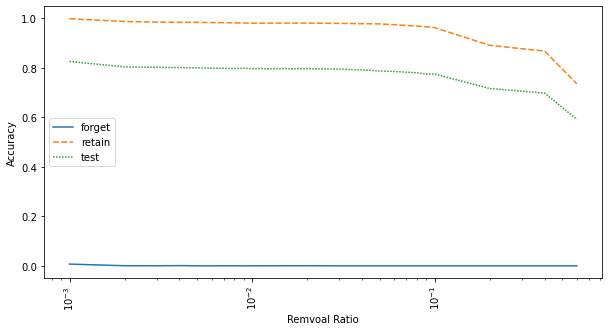

In [ ]:
plt.figure(figsize=(10,5))
df =pd.DataFrame(r_perf_1)
df.index=[ i for i in R_]
df.columns=['forget','retain','test']
sns.lineplot(data=df)
plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel('Remvoal Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
r_perf_1

[[0.007, 0.9988222222222222, 0.8262],
 [0.0004, 0.9875777777777778, 0.8041],
 [0.0002, 0.9852, 0.8024],
 [0.0008, 0.9841555555555556, 0.8016],
 [0.0, 0.9842666666666666, 0.8005],
 [0.0, 0.9830888888888889, 0.7989],
 [0.0002, 0.9830444444444445, 0.7983],
 [0.0002, 0.9821777777777778, 0.7975],
 [0.0, 0.9818222222222223, 0.7985],
 [0.0002, 0.9808, 0.7968],
 [0.0, 0.9809111111111111, 0.7969],
 [0.0004, 0.9811777777777778, 0.7967],
 [0.0, 0.9799555555555556, 0.7952],
 [0.0, 0.9788444444444444, 0.7918],
 [0.0, 0.9779111111111111, 0.7876],
 [0.0, 0.9748888888888889, 0.7857],
 [0.0, 0.9716, 0.7828],
 [0.0, 0.9694222222222222, 0.7803],
 [0.0, 0.9661555555555555, 0.7755],
 [0.0, 0.9627111111111111, 0.7752],
 [0.0, 0.8913555555555556, 0.7168],
 [0.0, 0.8678, 0.6981],
 [0.0, 0.7358, 0.5921]]

In [ ]:
from tools.Unlearner_FM import Unlearner_FM
r_perf_2=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)

    new_model_1,epoch_log=unlearner.fine_tune(new_model_1,retain_dataloader)
    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_2.append([forget_perf,retain_perf,test_perf,[epoch_log]])


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


 10%|█         | 1/10 [01:03<09:29, 63.30s/it]


KeyboardInterrupt: 

: 

## Run the unlearning


In [ ]:
### Getting the new model masked model

new_model_1, mask_index_1,num_of_param_1=unlearner_1.Fisher_Masking(retain_dataloader,forget_dataloader)

Finished Computing Hessian Diagonal
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


In [ ]:
Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')

0.0

In [ ]:
Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')

0.9576666666666667

In [ ]:
Unlearner_FM.test(new_model_1,testloader,'cuda')

0.7854

We can see that the unlearning process may need many epochs in the erasure phase to converge. We could also try to increase the learning rate for faster convergence.

In [ ]:
import pandas as pd
import seaborn as sns

log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n
unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'].max()
unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'].max()

sns.lineplot(data = unlearn_history, x = 'epoch', y='loss_scale', hue='phase')

## Check model performance
We now try check the model performance on the retain and forget set.

In [ ]:
models = {'original':model, 'dumb':unlearner.dumb_model, 'erased':unlearner.erased_model, 'retrained':unlearner.retrained_model}
dataloaders = {'retain':retain_dataloader, 'forget':forget_dataloader, 'test':testloader}

performances = []
for model_name, m in models.items():
  for dl_name, dl in dataloaders.items():
    acc = test(m, dl)
    performances.append((model_name, dl_name, acc))

Strangely the dumb network has 0% performance on the forget set, and this may have a negative impact, note that the performance on the forget set is even too low (we expected 10%, not less).

Outside of that we note that this procedure works great for the retain and test which are fitted very nicely, and we can even see that there's a big leap in performance from the erased model to the retrained model.

In [ ]:
perf_df = pd.DataFrame.from_records(performances, columns=['model', 'data_partition', 'accuracy'])

tb = pd.pivot_table(perf_df, index='data_partition', columns='model', values='accuracy')
sns.heatmap(tb, annot = True, fmt='.2%')